In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import nglview as nv
import protein
from protein.model_analysis import get_predicted_transformations, pca_latent_space, mask_evolution, plot_loss
from protein.main import rotate_residues, rotate_domain_pdb_structure_matrix, translate_residues, translate_domain_pdb_structure
from pytorch3d.transforms import matrix_to_axis_angle, axis_angle_to_matrix
from Bio.PDB import PDBParser
from Bio.PDB import PDBIO
from sklearn.decomposition import PCA
from pytorch3d.transforms import matrix_to_axis_angle, axis_angle_to_matrix, quaternion_to_axis_angle
from imageRenderer import Renderer

In [2]:
def sample_structure(latent_variables, model):
    batch_size = latent_variables.shape[0]
    model.batch_size = batch_size
    weights = model.compute_mask()
    output = model.decoder.forward(latent_variables)
    output = torch.reshape(output, (batch_size, model.N_domains,2*3))
    scalars_per_domain = output[:, :, :3]
    ones = torch.ones(size=(batch_size, model.N_domains, 1), device="cpu")
    quaternions_per_domain = torch.cat([ones,output[:, :, 3:]], dim=-1)
    rotations_per_residue = model.compute_rotations(quaternions_per_domain, weights)
    new_structure, translations = model.deform_structure(weights, scalars_per_domain, rotations_per_residue)
    return translations, rotations_per_residue, quaternion_to_axis_angle(quaternions_per_domain)

def matrix_to_axis_angles(rotation_matrices):
    axis_angle = matrix_to_axis_angle(rotation_matrices)
    angle = torch.sqrt(torch.sum(axis_angle**2, dim=-1))
    axis = axis_angle/angle[:, :, None]
    return angle.detach().numpy(), axis.detach().numpy()

def get_axis_and_angle(axis_angle):
    angle = torch.sqrt(torch.sum(axis_angle**2, dim=-1))
    axis = axis_angle/angle[:, :, None]
    return angle.detach().numpy(), axis.detach().numpy()

## I. A bit of context

The images are 64x64 pixels. For a pixel size of roughly 4.7 Å.

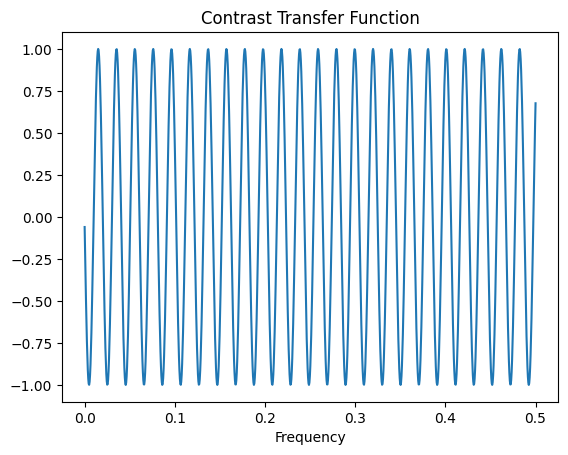

In [3]:
ctf = np.load("data/ctf.npy")
freq = np.linspace(0, 0.5, 1000)
plt.plot(freq, ctf)
plt.title("Contrast Transfer Function")
plt.xlabel("Frequency")
plt.savefig("data/meetingSebastian16032023/ctf.png")
plt.show()

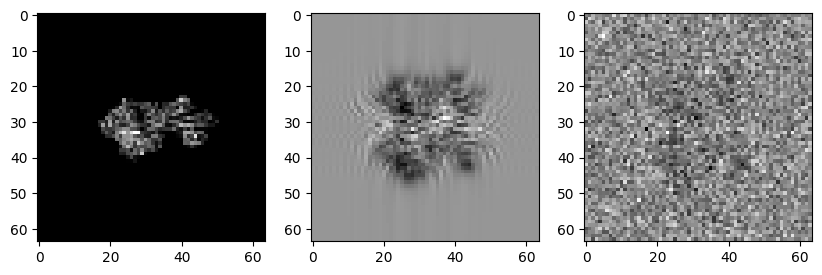

In [550]:
ctf_image = np.load("data/ctf_corrupted.npy")
no_ctf_image = np.load("data/no_ctf_corrupted.npy")
fig, axs = plt.subplots(1,3, figsize=(10, 10))
axs[0].imshow(no_ctf_image, cmap="gray")
axs[1].imshow(ctf_image, cmap="gray")
axs[2].imshow(ctf_image + np.sqrt(0.2)*np.random.normal(size=(64, 64)), cmap="gray")
#plt.savefig("data/meetingSebastian16032023/protein.png")
plt.show()


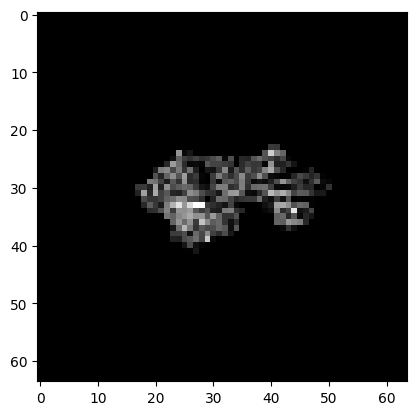

In [7]:
ctf_image = np.load("data/no_ctf_corrupted.npy")
plt.imshow(ctf_image, cmap="gray")
plt.savefig("data/meetingSebastian16032023/protein.png")
plt.show()

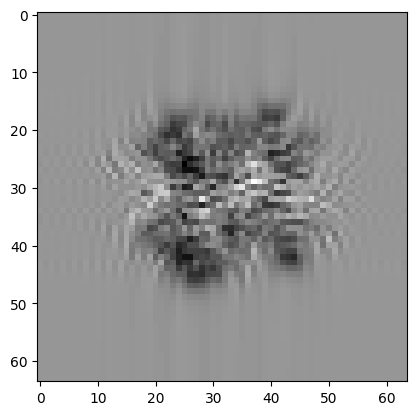

In [5]:
ctf_image = np.load("data/ctf_corrupted.npy")
plt.imshow(ctf_image, cmap="gray")
plt.savefig("data/meetingSebastian16032023/proteinCTF.png")
plt.show()

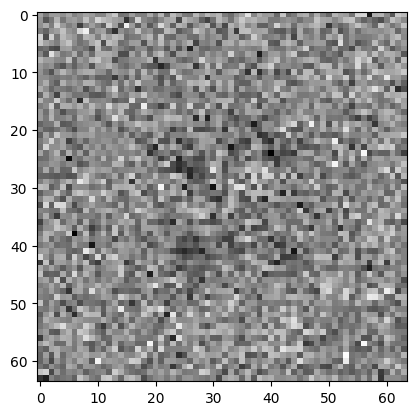

In [6]:
ctf_image = np.load("data/ctf_corrupted.npy")
plt.imshow(ctf_image + np.random.normal(size=ctf_image.shape)*np.sqrt(0.2), cmap="gray")
plt.savefig("data/meetingSebastian16032023/proteinCTFNoise.png")
plt.show()

## II. Continuous distribution

### A. Training set

In [57]:
path = "data/vaeContinuousOld/"

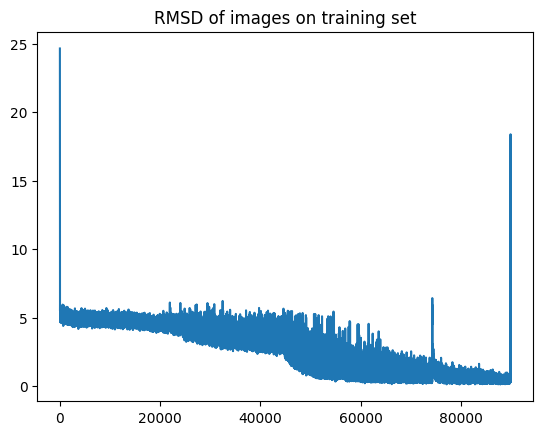

In [67]:
rmsd = np.load(path + "losses_rmsd.npy")
plt.plot(rmsd[:89980])
plt.title("RMSD of images on training set")
plt.show()

In [8]:
plt.style.use("ggplot")

In [3]:
mask_evol = mask_evolution("data/vaeContinuousNew/")

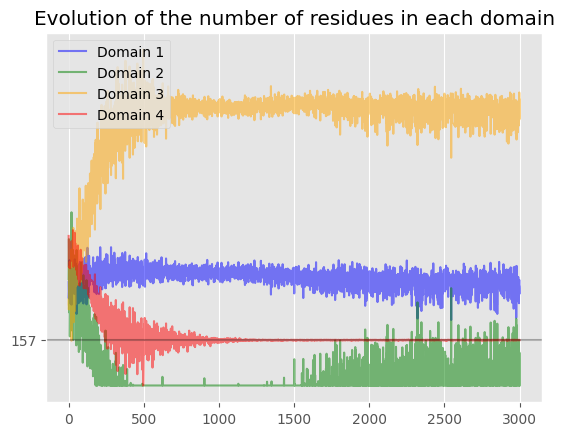

In [9]:
plt.plot(mask_evol[:, 0], label="Domain 1", alpha=0.5, color="blue")
plt.plot(mask_evol[:, 1], label="Domain 2", alpha=0.5, color="green")
plt.plot(mask_evol[:, 2], label="Domain 3", alpha=0.5, color="orange")
plt.plot(mask_evol[:, 3], label="Domain 4", alpha=0.5, color="red")
plt.axhline(y=157, alpha=0.3, color="black")
plt.yticks([157])
plt.legend(loc="upper left")
plt.title("Evolution of the number of residues in each domain")
plt.savefig("data/meetingSebastian16032023/mask_evol.png")
plt.show()

In [10]:
latent_distrib = np.load("data/vaeContinuous/latent_distrib.npy")
indexes = np.load("data/vaeContinuous/indexes.npy")
all_latent_distrib = np.concatenate(latent_distrib, axis= 0)
all_indexes = np.concatenate(indexes, axis= 0)

In [11]:
model = torch.load("data/vaeContinuous/full_model", map_location=torch.device('cpu'))
model.batch_size = 10000
model.device = "cpu"

In [12]:
translations_training, rotations_per_residue_training, axis_angle_domain_training = sample_structure(torch.tensor(all_latent_distrib[:, :1])
                                                                                                     , model)

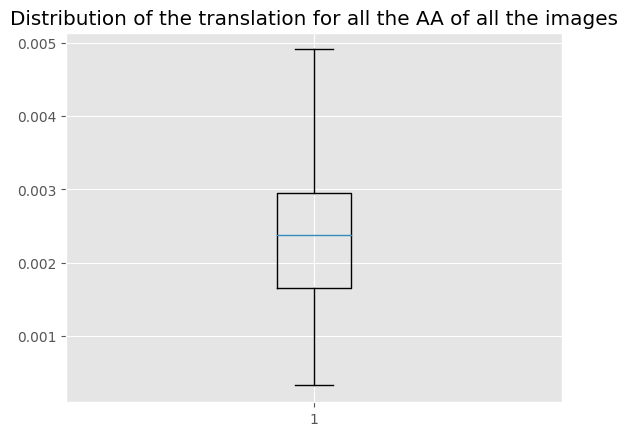

In [13]:
translations_magnitude_training = torch.sqrt(torch.sum(translations_training**2, dim=-1))
plt.boxplot(translations_magnitude_training.flatten().detach().numpy(), showfliers=False)
plt.title("Distribution of the translation for all the AA of all the images")
plt.savefig("data/meetingSebastian16032023/continuous/displacement.png")
plt.show()

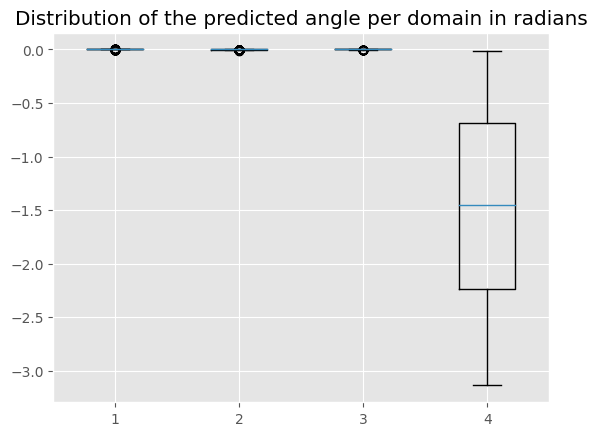

In [14]:
angle_training, axis_training = get_axis_and_angle(axis_angle_domain_training)
angle_training *= -1
axis_training *= -1
plt.boxplot(angle_training[:, :], showfliers=True)
plt.title("Distribution of the predicted angle per domain in radians")
plt.savefig("data/meetingSebastian16032023/continuous/distribution_angle.png")
plt.show()

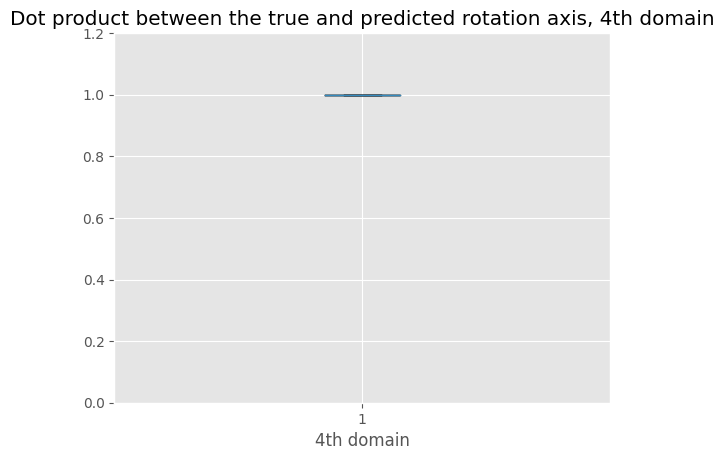

In [16]:
dot_prod = np.matmul(axis_training[:, 3, :], np.array([0.0, 1.0, 0.0]))
plt.boxplot(dot_prod, showfliers=False)
plt.ylim([0, 1.2])
plt.xlabel("4th domain")
plt.title("Dot product between the true and predicted rotation axis, 4th domain")
plt.savefig("data/meetingSebastian16032023/continuous/dot_product.png")
plt.show()

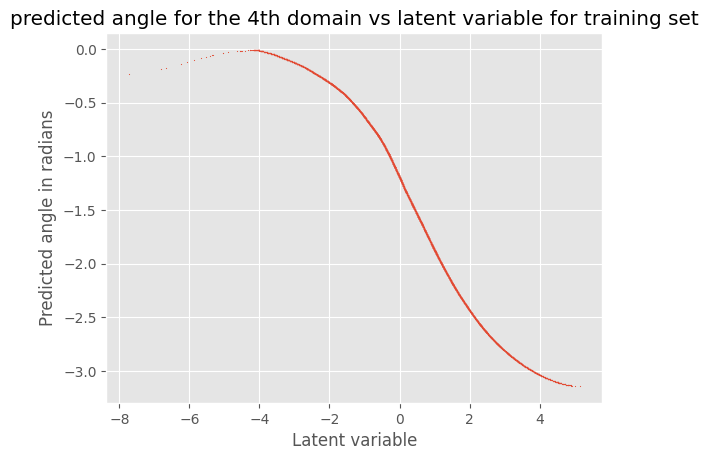

Correlation: [[ 1.         -0.97892201]
 [-0.97892201  1.        ]]


In [17]:
plt.scatter(all_latent_distrib[:, 0], angle_training[:, 3], s=0.1)
plt.xlabel("Latent variable")
plt.ylabel("Predicted angle in radians")
plt.title("predicted angle for the 4th domain vs latent variable for training set")
plt.savefig("data/meetingSebastian16032023/continuous/trueAngleVSlatentVar.png")
plt.show()
print("Correlation:", np.corrcoef(all_latent_distrib[:, 0], angle_training[:, 3]))

In [20]:
true_rot_mat_training = torch.load(path + "training_conformation_rotation_matrices.npy", 
                          map_location=torch.device('cpu'))
true_axis_angle_training = matrix_to_axis_angle(true_rot_mat_training)
true_angles_training = torch.sqrt(torch.sum(true_axis_angle_training[:, 2, :]**2, dim=-1))
true_axis_training = true_axis_angle_training[:, 3]/true_angles_training[:, None]
true_angles_training *= -1

In [21]:
#First we set the angle to the range [-pi, pi] and then we minus the angle because we change the axis
#from [0, -1, 0] to [0, 1, 0]
true_angles_training[true_angles_training < -np.pi] = -(true_angles_training[true_angles_training < -np.pi] + 2*np.pi)

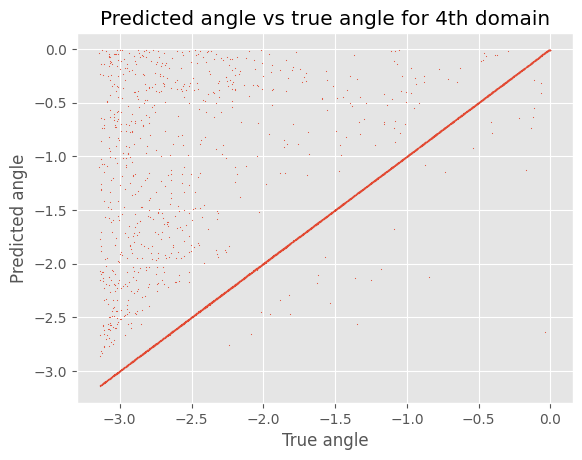

Correlation: [[1.         0.88786566]
 [0.88786566 1.        ]]


In [22]:
plt.scatter(true_angles_training, angle_training[:, 3], s=0.1)
plt.xlabel("True angle")
plt.ylabel("Predicted angle")
plt.title("Predicted angle vs true angle for 4th domain")
plt.savefig("data/meetingSebastian16032023/continuous/trueAngleVSpredictedAngle.png")
plt.show()
print("Correlation:", np.corrcoef(true_angles_training, angle_training[:, 3]))

In [284]:
#pdb_parser = PDBParser()
#io = PDBIO()
#for i in range(10000):
#    if i%100 == 0:
#        print(i)
#        
#    struct = pdb_parser.get_structure("A", "data/vaeContinuous/ranked_0.pdb")
#    protein.main.rotate_domain_pdb_structure_matrix(struct, 1353, 1510, true_rot_mat[i, 2, :, :], local_frame_in_columns)
#    io.set_structure(struct)
#    io.save("data/vaeContinuous/true_structures/true_structure"+str(i)+".pdb", preserve_atom_numbering = True)

In [285]:
#pdb_parser = PDBParser()
#io = PDBIO()
#for i in range(0, 10000):
#    if i%100 == 0:
#        print(i)
        
#    struct = pdb_parser.get_structure("A", "data/vaeContinuous/ranked_0.pdb")
#    protein.main.rotate_residues(struct, rotations_per_residue_np[i], local_frame_in_columns)
#    io.set_structure(struct)
#    io.save("data/vaeContinuous/predicted_structures/predicted"+str(i)+".pdb", preserve_atom_numbering = True)
    

In [286]:
#all_rmsd = {}
#for i in range(10000):
#    true = "data/vaeContinuous/true_structures/true_structure"+str(i)+".pdb"
#    predicted = "data/vaeContinuous/predicted_structures/predicted"+str(i)+".pdb"
#    rmsd = protein.main.compute_rmsd_pdb(true, predicted)
#    print(i, rmsd)
#    all_rmsd["predicted"+str(i)+".pdb"] = rmsd

In [287]:
#with open("data/vaeContinuous/predicted_structures/rmsd.txt", "w") as f:
#    for i, tup in enumerate(sorted_rmsd):
#        print(i)
#        f.write(f"{tup[0]}\t {tup[1]}\n")

### B. Test set

In [290]:
latent_distrib_test = np.load("data/vaeContinuous/test_run/latent_distrib.npy")
indexes = np.load("data/vaeContinuous/test_run/indexes.npy")
all_latent_distrib_test = np.concatenate(latent_distrib_test, axis= 0)
all_indexes = np.concatenate(indexes, axis= 0)

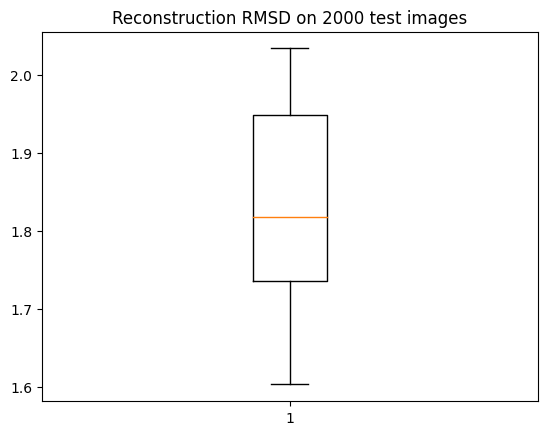

In [291]:
test_rmsd = np.load("data/vaeContinuous/test_run/losses_rmsd.npy")
plt.boxplot(test_rmsd)
plt.title("Reconstruction RMSD on 2000 test images")
plt.show()

In [295]:
translations_test, rotations_per_residue_test, axis_angle_domain_test = sample_structure(torch.tensor(all_latent_distrib_test[:, :1])
                                                                                                     , model)

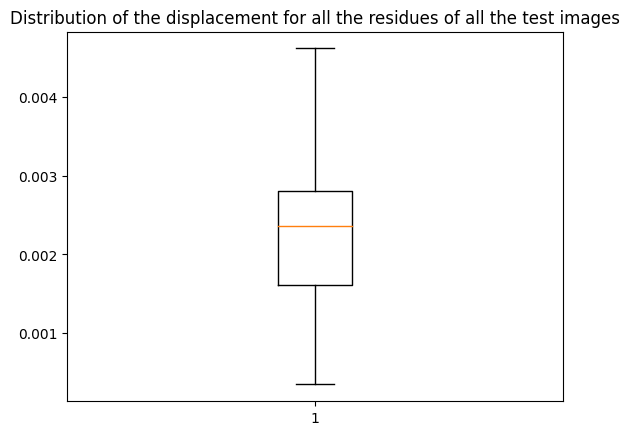

In [296]:
translations_magnitude_test = torch.sqrt(torch.sum(translations_test**2, dim=-1))
plt.boxplot(translations_magnitude_test.flatten().detach().numpy(), showfliers=False)
plt.title("Distribution of the displacement for all the residues of all the test images")
plt.show()

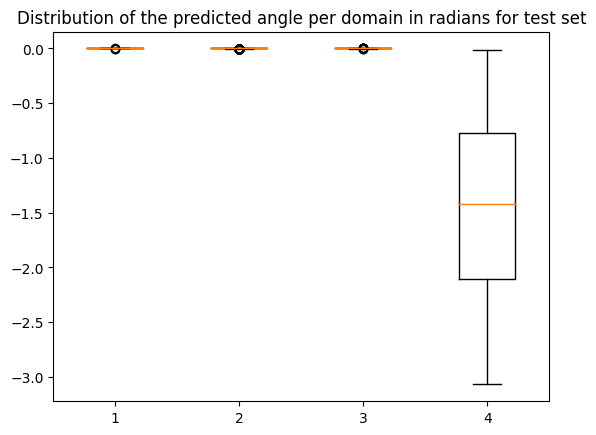

In [297]:
angle_test, axis_test = get_axis_and_angle(axis_angle_domain_test)
angle_test *= -1
axis_test *= -1
plt.boxplot(angle_test[:, :], showfliers=True)
plt.title("Distribution of the predicted angle per domain in radians for test set")
plt.show()

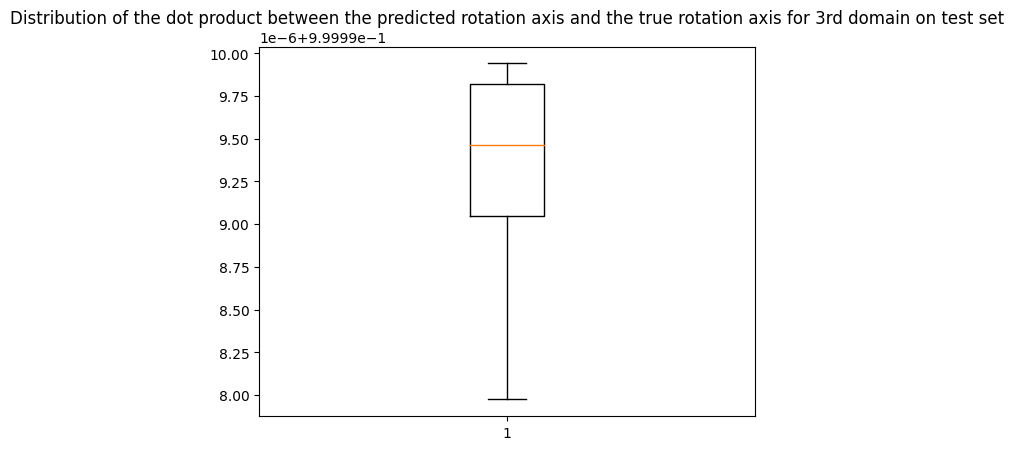

In [298]:
dot_prod_test = np.matmul(axis_test[:, 3, :], np.array([0.0, 1.0, 0.0]))
plt.boxplot(dot_prod_test, showfliers=False)
plt.title("Distribution of the dot product between the predicted rotation axis and the true rotation axis for 3rd domain on test set")
plt.show()

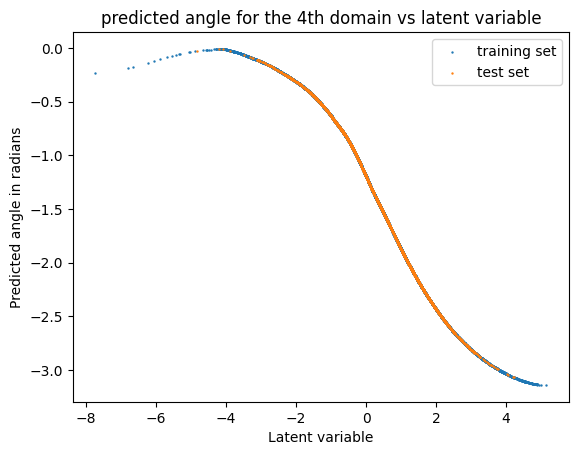

Correlation: [[ 1.         -0.98747948]
 [-0.98747948  1.        ]]


In [383]:
plt.scatter(all_latent_distrib[:, 0], angle_training[:, 3], s=0.5, label="training set")
plt.scatter(all_latent_distrib_test[:, 0], angle_test[:, 3], s=0.5, label="test set")
plt.xlabel("Latent variable")
plt.ylabel("Predicted angle in radians")
plt.title("predicted angle for the 4th domain vs latent variable")
plt.legend(loc="upper right")
plt.savefig("data/meetingSebastian16032023/continuous/trueAngleVSlatentVarTest.png")
plt.show()
print("Correlation:", np.corrcoef(all_latent_distrib_test[:, 0], angle_test[:, 3]))

In [384]:
true_rot_mat_test = torch.load("data/vaeContinuous/test_run/test_conformation_rotation_matrices.npy", 
                          map_location=torch.device('cpu'))
true_axis_angle_test = matrix_to_axis_angle(true_rot_mat_test)
true_angles_test = torch.sqrt(torch.sum(true_axis_angle_test[:, 2, :]**2, dim=-1))
true_axis_test = true_axis_angle_test[:, 3]/true_angles_test[:, None]
true_angles_test *= -1

In [385]:
#First we set the angle to the range [-pi, pi] and then we minus the angle because we change the axis
#from [0, -1, 0] to [0, 1, 0]
true_angles_test[true_angles_test < -np.pi] = -(true_angles_test[true_angles_test < -np.pi] + 2*np.pi)

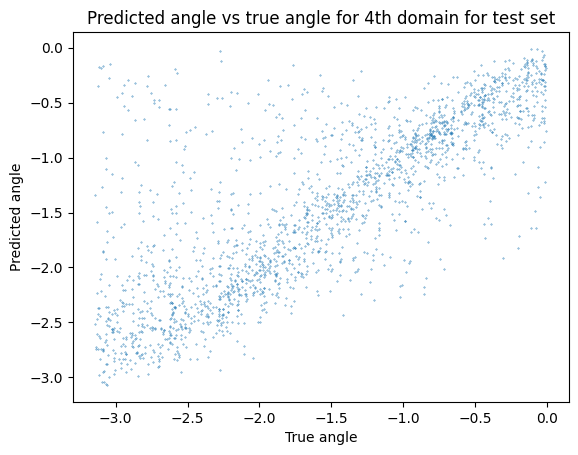

Correlation: [[1.         0.77576544]
 [0.77576544 1.        ]]


In [386]:
plt.scatter(true_angles_test, angle_test[:, 3], s=0.1)
plt.xlabel("True angle")
plt.ylabel("Predicted angle")
plt.title("Predicted angle vs true angle for 4th domain for test set")
plt.savefig("data/meetingSebastian16032023/continuous/trueAngleVSpredictedAngleTest.png")
plt.show()
print("Correlation:", np.corrcoef(true_angles_test, angle_test[:, 3]))

In [304]:
#pdb_parser = PDBParser()
#io = PDBIO()
#for i in range(0, 2000):
#    if i%100 == 0:
#        print(i)
        
#    struct = pdb_parser.get_structure("A", "data/vaeContinuous/ranked_0.pdb")
#    protein.main.rotate_residues(struct, rotations_per_residue_np[i], local_frame_in_columns)
#    io.set_structure(struct)
#    io.save("data/vaeContinuous/test_run/predicted_structures/predicted"+str(i)+".pdb", preserve_atom_numbering = True)
    

In [305]:
#pdb_parser = PDBParser()
#io = PDBIO()
#for i in range(2000):
#    if i%100 == 0:
#        print(i)
        
#    struct = pdb_parser.get_structure("A", "data/vaeContinuous/ranked_0.pdb")
#    protein.main.rotate_domain_pdb_structure_matrix(struct, 1353, 1510, true_rot_mat[i, 2, :, :], local_frame_in_columns)
#    io.set_structure(struct)
#    io.save("data/vaeContinuous/test_run/true_structures/true_structure"+str(i)+".pdb", preserve_atom_numbering = True)

In [306]:
#all_rmsd = {}
#for i in range(2000):
#    true = "data/vaeContinuous/test_run/true_structures/true_structure"+str(i)+".pdb"
#    predicted = "data/vaeContinuous/test_run/predicted_structures/predicted"+str(i)+".pdb"
#    rmsd = protein.main.compute_rmsd_pdb(true, predicted)
#    print(i, rmsd)
#    all_rmsd["predicted"+str(i)+".pdb"] = rmsd

In [307]:
#sorted_rmsd = sorted(list(all_rmsd.items()), key = lambda x: x[1])

In [650]:
#with open("data/vaeContinuous/test_run/predicted_structures/rmsd.txt", "w") as f:
#    for i, tup in enumerate(sorted_rmsd):
#        print(i)
#        f.write(f"{tup[0]}\t {tup[1]}\n")

In [457]:
interpol_latent = torch.tensor(np.linspace(-4, 4, 10), dtype=torch.float32)[:, None]
translations_interpol, rotation_per_residues_interpol, axis_angle_domain_interpol = sample_structure(interpol_latent, model)
angle, axis = matrix_to_axis_angles(torch.tensor(rotation_per_residues_interpol))

/var/folders/6m/46qftl4j0kjcyvy_lh05f3_w00ztgk/T/ipykernel_78705/2264170786.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  angle, axis = matrix_to_axis_angles(torch.tensor(rotation_per_residues_interpol))


In [501]:
pdb_parser = PDBParser()
io = PDBIO()
for i in range(0, 10):        
    struct = pdb_parser.get_structure("A", "data/vaeContinuous/ranked_0.pdb")
    protein.main.rotate_residues(struct, rotation_per_residues_interpol[i].detach().numpy(), local_frame_in_columns)
    io.set_structure(struct)
    io.save("data/vaeContinuous/test_run/interpolation/predicted"+str(i)+".pdb", preserve_atom_numbering = True)
    

## II. 2 conformations

### A. Training set

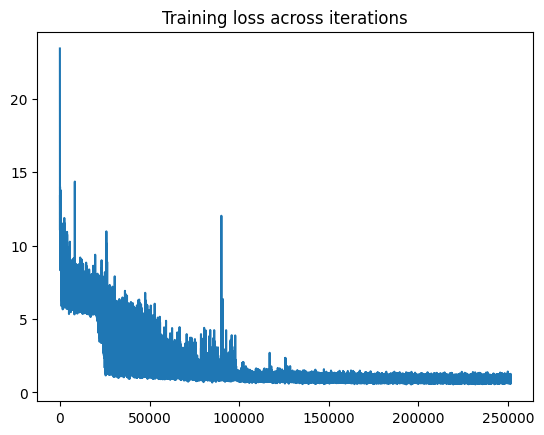

In [388]:
rmsd = np.load("data/vae2Conformations/losses_rmsd.npy")
plt.plot(rmsd)
plt.title("Training loss across iterations")
plt.show()

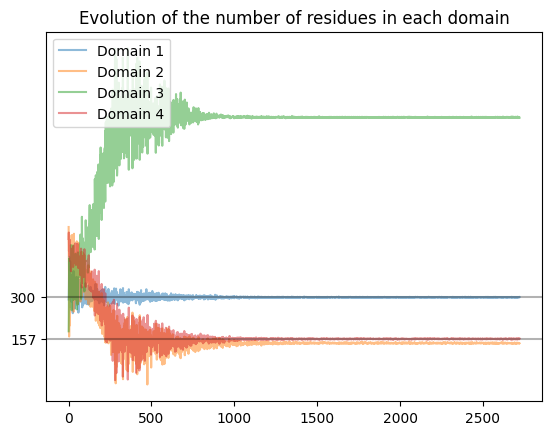

In [389]:
mask_evol = mask_evolution("data/vae2Conformations/masks/")
plt.plot(mask_evol[:, 0], label="Domain 1", alpha=0.5)
plt.plot(mask_evol[:, 1], label="Domain 2", alpha=0.5)
plt.plot(mask_evol[:, 2], label="Domain 3", alpha=0.5)
plt.plot(mask_evol[:, 3], label="Domain 4", alpha=0.5)
plt.axhline(y=157, alpha=0.3, color="black")
plt.axhline(y=300, alpha=0.3, color="black")
plt.yticks([157, 300])
plt.legend(loc="upper left")
plt.title("Evolution of the number of residues in each domain")
plt.savefig("data/meetingSebastian16032023/2conformations/mask_evol.png")
plt.show()

In [390]:
latent_distrib = np.load("data/vae2Conformations/latent_distrib.npy")
indexes = np.load("data/vae2Conformations/indexes.npy")
all_latent_distrib = np.concatenate(latent_distrib, axis= 0)
all_indexes = np.concatenate(indexes, axis= 0)
pca = PCA()
pca_latent = pca.fit_transform(all_latent_distrib[:, :9])
cols = ["blue" if i < 5000 else "red" for i in all_indexes]

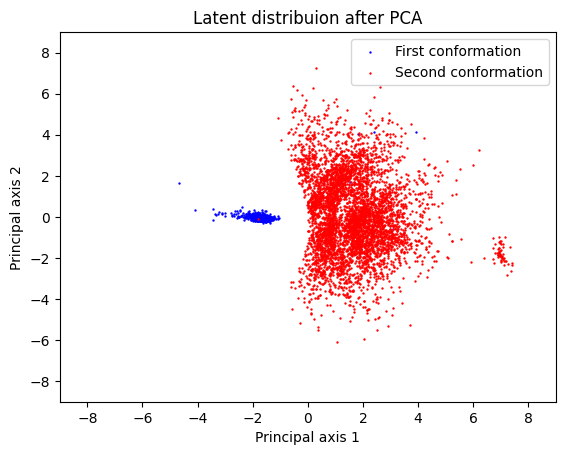

In [391]:
plt.scatter(pca_latent[:5000, 0], pca_latent[:5000, 1], s=0.5, color="blue", label="First conformation")
plt.scatter(pca_latent[5000:, 0], pca_latent[5000:, 1], s=0.5, color="red", label="Second conformation")
plt.xlim([-9, 9])
plt.ylim([-9, 9])
plt.xlabel("Principal axis 1")
plt.ylabel("Principal axis 2")
plt.legend(loc="upper right")
plt.title("Latent distribuion after PCA")
plt.savefig("data/meetingSebastian16032023/2conformations/latentVar.png")
plt.show()

In [392]:
model = torch.load("data/vae2Conformations/full_model", map_location=torch.device('cpu'))
model.device = "cpu"

In [393]:
translations_training, rotations_per_residue_training, axis_angle_per_domain_training = sample_structure(
    torch.tensor(all_latent_distrib[:, :9], dtype=torch.float32), model)

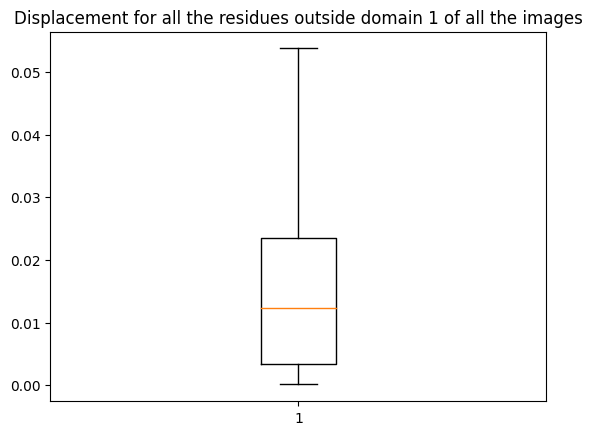

In [402]:
translations_magnitude_training = torch.sqrt(torch.sum(translations_training**2, dim=-1))
plt.boxplot(translations_magnitude_training[:, 300:].flatten().detach().numpy(), showfliers=False)
plt.title("Displacement for all the residues outside domain 1 of all the images")
plt.savefig("data/meetingSebastian16032023/2conformations/displacementAll.png")
plt.show()

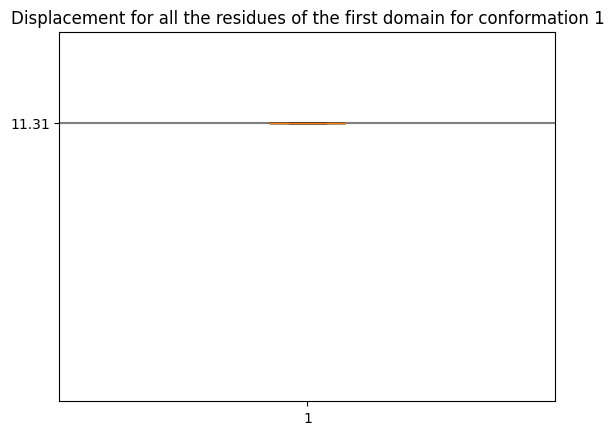

In [403]:
translations_magnitude_training = torch.sqrt(torch.sum(translations_training**2, dim=-1))
plt.boxplot(translations_magnitude_training[:5000, :300].flatten().detach().numpy(), showfliers=False)
plt.title("Displacement for all the residues of the first domain for conformation 1")
plt.ylim([0, 15])
plt.axhline(y=11.313708498984761, color="black", alpha=0.5)
plt.yticks([11.3137])
plt.savefig("data/meetingSebastian16032023/2conformations/displacement1stDomain.png")
plt.show()

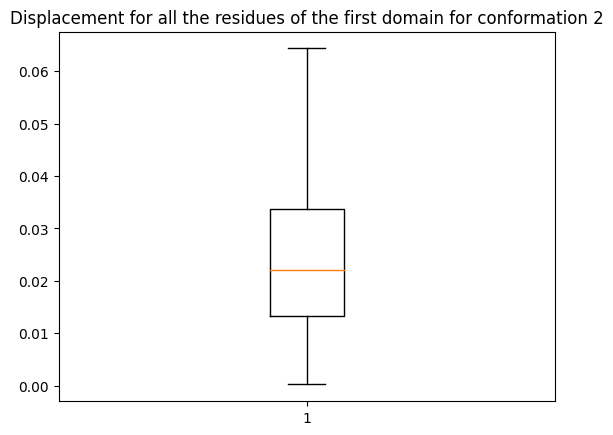

In [404]:
translations_magnitude_training = torch.sqrt(torch.sum(translations_training**2, dim=-1))
plt.boxplot(translations_magnitude_training[5000:, :300].flatten().detach().numpy(), showfliers=False)
plt.title("Displacement for all the residues of the first domain for conformation 2")
plt.savefig("data/meetingSebastian16032023/2conformations/displacement1stDomainConf2.png")
plt.show()

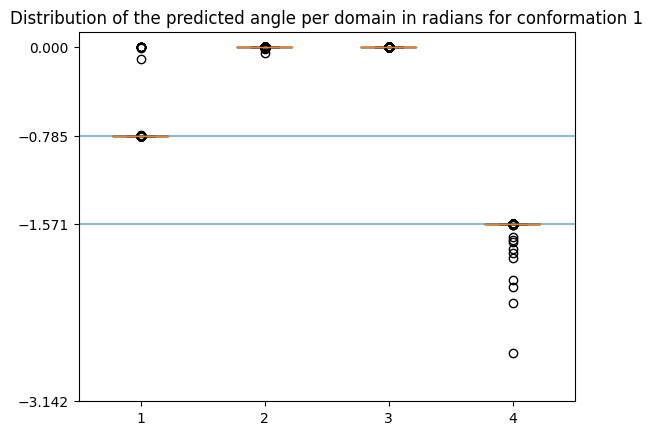

In [397]:
angle_training, axis_training = get_axis_and_angle(axis_angle_per_domain_training)
angle_training *= -1
axis_training *= -1
plt.boxplot(angle_training[:5000, :], showfliers=True)
plt.title("Distribution of the predicted angle per domain in radians for conformation 1")
plt.yticks([0, -np.pi/4, -np.pi/2, -np.pi])
plt.axhline(y=-np.pi/4, alpha = 0.5)
plt.axhline(y=-np.pi/2, alpha = 0.5)
plt.savefig("data/meetingSebastian16032023/2conformations/predictedAngleConf1.png")
plt.show()

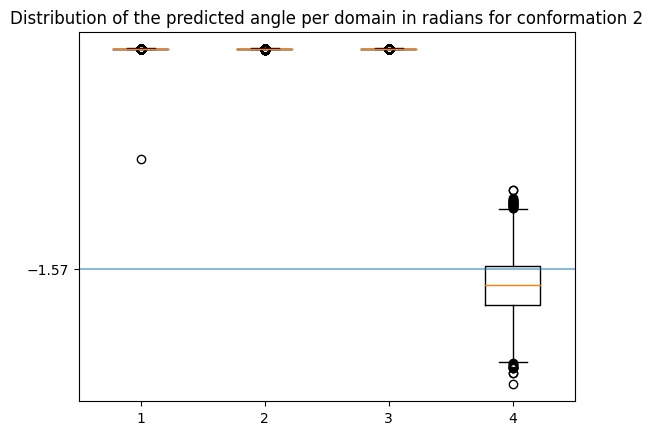

In [398]:
angle_training, axis_training = get_axis_and_angle(axis_angle_per_domain_training)
angle_training *= -1
axis_training *= -1
plt.boxplot(angle_training[5000:, :], showfliers=True)
plt.title("Distribution of the predicted angle per domain in radians for conformation 2")
plt.yticks([-np.pi/2])
plt.axhline(y=-np.pi/2, alpha = 0.5)
plt.savefig("data/meetingSebastian16032023/2conformations/predictedAngleConf2.png")
plt.show()

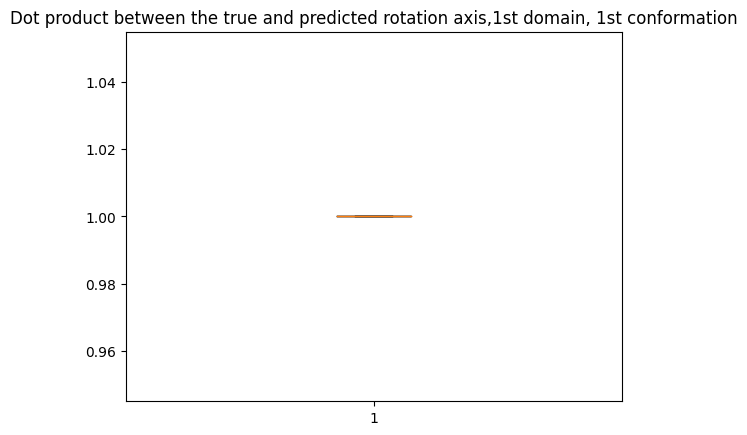

In [399]:
dot_prod = np.matmul(axis_training[:5000, 0, :], np.array([0.0, 0.0, 1.0]))
plt.boxplot(dot_prod, showfliers=False)
plt.title("Dot product between the true and predicted rotation axis,1st domain, 1st conformation")
plt.savefig("data/meetingSebastian16032023/2conformations/dotProdConf1FirstDomain.png")
plt.show()

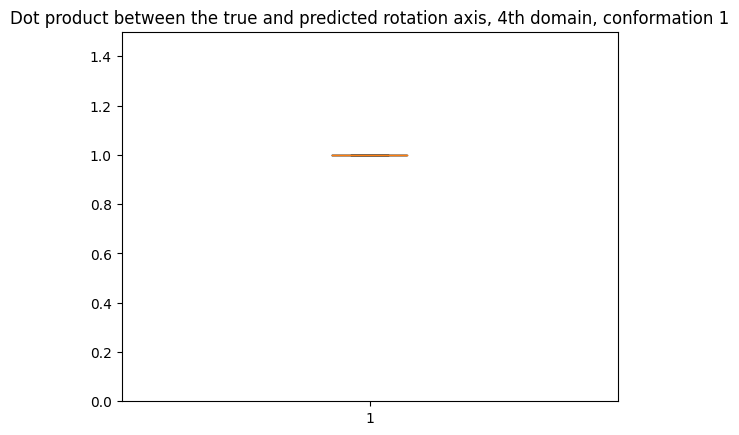

In [400]:
dot_prod = np.matmul(axis_training[:5000, 3, :], np.array([0.0, -1.0, 0.0]))
plt.boxplot(dot_prod, showfliers=False)
plt.title("Dot product between the true and predicted rotation axis, 4th domain, conformation 1")
plt.ylim([0, 1.5])
plt.savefig("data/meetingSebastian16032023/2conformations/dotProdConf13rdDomain.png")
plt.show()

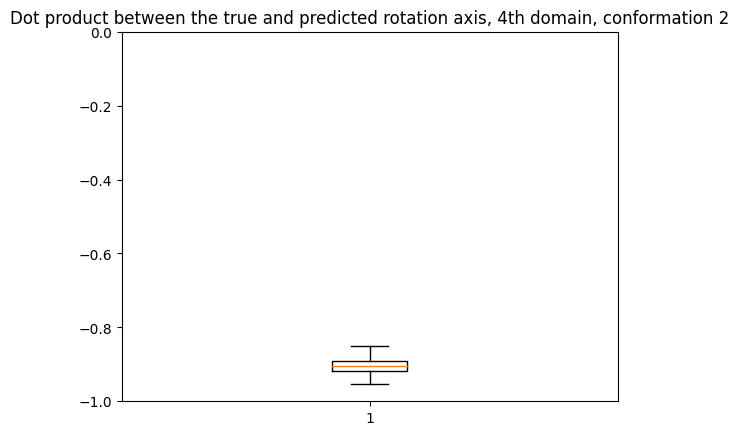

In [401]:
dot_prod = np.matmul(axis_training[5000:, 3, :], np.array([0.0, 1.0, 0.0]))
plt.boxplot(dot_prod, showfliers=False)
plt.title("Dot product between the true and predicted rotation axis, 4th domain, conformation 2")
plt.ylim([-1, 0])
plt.savefig("data/meetingSebastian16032023/2conformations/dotProdConf23rdDomain.png")
plt.show()

In [779]:
#pdb_parser = PDBParser()
#io = PDBIO()
#for i in range(5000, 10000):
#    if i%100 == 0:
#        print(i)
        
#    struct = pdb_parser.get_structure("A", "data/vae2Conformations/ranked_0.pdb")
#    protein.main.rotate_residues(struct, rotations_per_residue_np[i], local_frame_in_columns)
#    protein.main.translate_residues(struct, translations_np[i])
#    io.set_structure(struct)
#    io.save("data/vae2Conformations/conformation2/predicted"+str(i)+".pdb", preserve_atom_numbering = True)
    

In [ ]:
#rotations = torch.load("data/vae2Conformations/training_conformation_rotation_matrices.npy", map_location=torch.device('cpu'))
#translations = torch.load("data/vae2Conformations/training_set.npy", map_location=torch.device('cpu'))

In [ ]:
#pdb_parser = PDBParser()
#io = PDBIO()
#struct = pdb_parser.get_structure("A", "data/vae2Conformations/ranked_0.pdb")
#protein.main.rotate_domain_pdb_structure_matrix(struct, 0, 300, rotations[6000, 0, :, :], local_frame_in_columns)
#protein.main.rotate_domain_pdb_structure_matrix(struct, 1353, 1510, rotations[6000, 2, :, :], local_frame_in_columns)
#protein.main.translate_domain_pdb_structure(struct, 0, 300, translations[6000, :3])
#io.set_structure(struct)
#io.save("data/vae2Conformations/conformation2/true_structure.pdb", preserve_atom_numbering = True)

In [ ]:
#import os
#all_rmsd = {}
#all_files = [f for f in os.listdir("data/vae2Conformations/conformation2/") if f !="true_structure.pdb"]
#for i, file in enumerate(all_files):
#    rmsd = protein.main.compute_rmsd_pdb("data/vae2Conformations/conformation2/true_structure.pdb", "data/vae2Conformations/conformation2/"+file)
#    print(i, rmsd)
#    all_rmsd[file] = rmsd

In [ ]:
#sorted_rmsd = sorted(list(all_rmsd.items()), key = lambda x: x[1])

In [780]:
#with open("data/vae2Conformations/conformation2/rmsd.txt", "w") as f:
#    for i, tup in enumerate(sorted_rmsd):
#        print(i)
#        f.write(f"{tup[0]}\t {tup[1]}\n")

### B. Test set

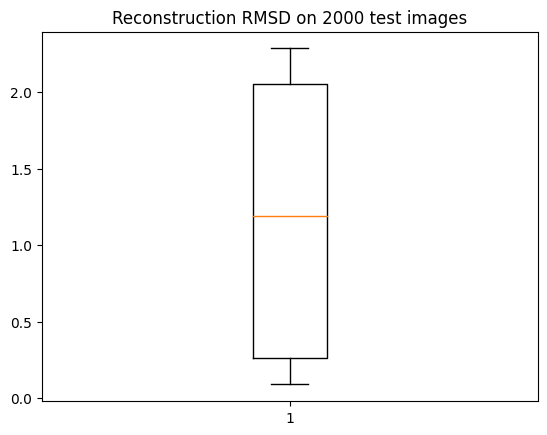

In [782]:
test_rmsd = np.load("data/vae2Conformations/test_run/losses_rmsd.npy")
plt.boxplot(test_rmsd)
plt.title("Reconstruction RMSD on 2000 test images")
plt.show()

In [748]:
latent_distrib_test = np.load("data/vae2Conformations/test_run/latent_distrib.npy")
indexes = np.load("data/vae2Conformations/indexes.npy")
all_latent_distrib_test = np.concatenate(latent_distrib_test, axis= 0)
all_indexes = np.concatenate(indexes, axis= 0)
cols = ["blue" if i < 5000 else "red" for i in all_indexes]

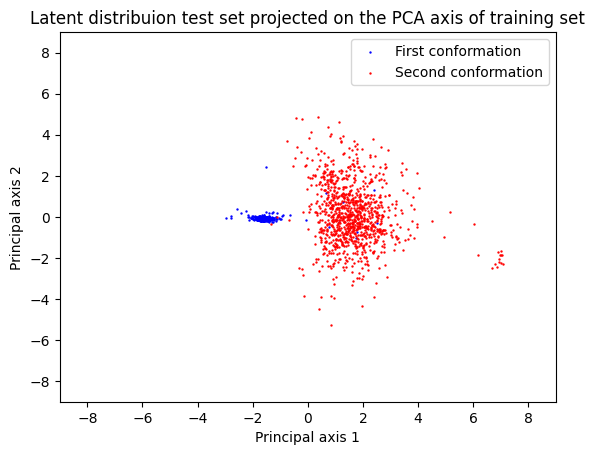

In [752]:
pca_latent_test = pca.transform(all_latent_distrib_test[:, :9])
plt.scatter(pca_latent_test[:1000, 0], pca_latent_test[:1000, 1], s=0.5, color="blue", label="First conformation")
plt.scatter(pca_latent_test[1000:, 0], pca_latent_test[1000:, 1], s=0.5, color="red", label="Second conformation")
plt.xlim([-9, 9])
plt.ylim([-9, 9])
plt.xlabel("Principal axis 1")
plt.ylabel("Principal axis 2")
plt.legend(loc="upper right")
plt.title("Latent distribuion test set projected on the PCA axis of training set")
plt.show()

In [753]:
translations_test, rotations_per_residue_test, axis_angle_per_domain_test = sample_structure(
    torch.tensor(all_latent_distrib_test[:, :9], dtype=torch.float32), model)

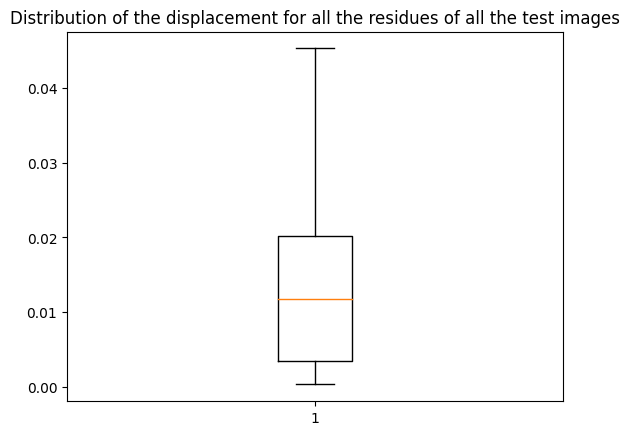

In [754]:
translations_magnitude_test = torch.sqrt(torch.sum(translations_test**2, dim=-1))
plt.boxplot(translations_magnitude_test[:, 300:].flatten().detach().numpy(), showfliers=False)
plt.title("Distribution of the displacement for all the residues of all the test images")
plt.show()

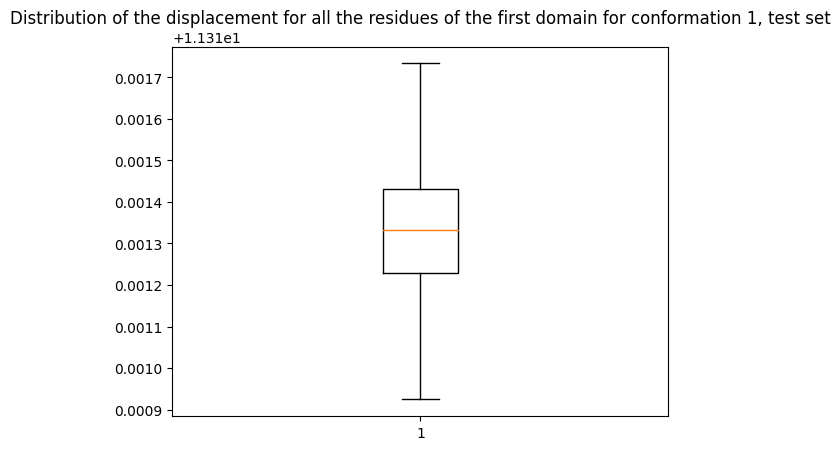

In [755]:
translations_magnitude_test = torch.sqrt(torch.sum(translations_test**2, dim=-1))
plt.boxplot(translations_magnitude_training[:1000, :300].flatten().detach().numpy(), showfliers=False)
plt.title("Distribution of the displacement for all the residues of the first domain for conformation 1, test set")
plt.show()

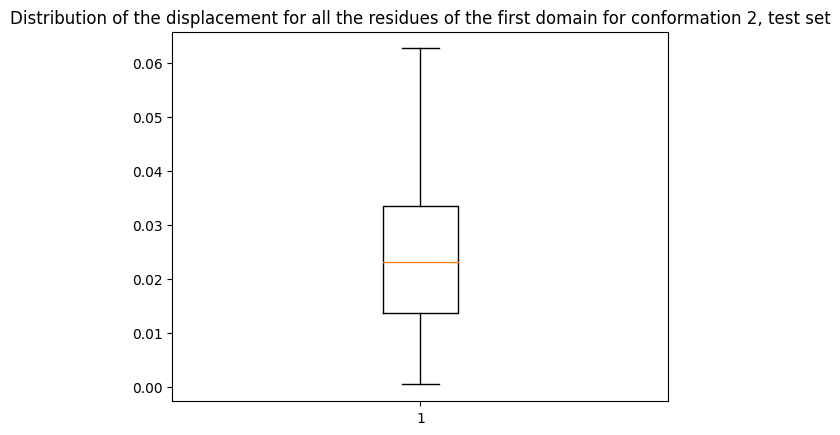

In [759]:
translations_magnitude_test = torch.sqrt(torch.sum(translations_test**2, dim=-1))
plt.boxplot(translations_magnitude_test[1000:, :300].flatten().detach().numpy(), showfliers=False)
plt.title("Distribution of the displacement for all the residues of the first domain for conformation 2, test set")
plt.show()

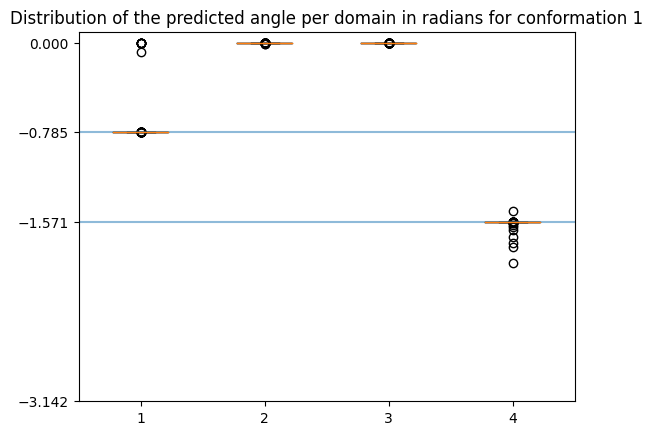

In [761]:
angle_test, axis_test = get_axis_and_angle(axis_angle_per_domain_test)
angle_test *= -1
axis_test *= -1
plt.boxplot(angle_test[:1000, :], showfliers=True)
plt.title("Distribution of the predicted angle per domain in radians for conformation 1")
plt.yticks([0, -np.pi/4, -np.pi/2, -np.pi])
plt.axhline(y=-np.pi/4, alpha = 0.5)
plt.axhline(y=-np.pi/2, alpha = 0.5)
plt.show()

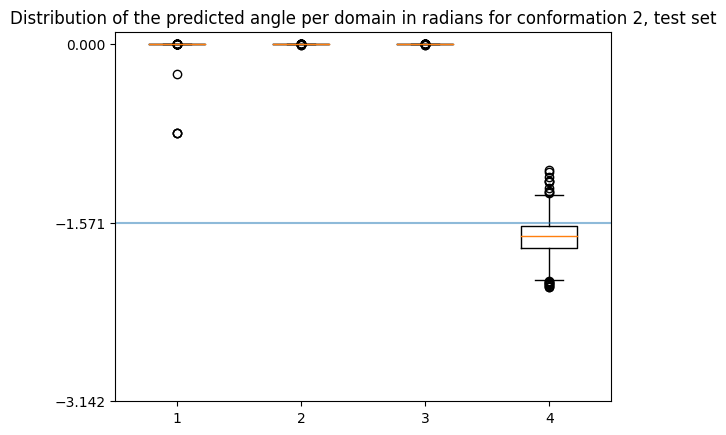

In [764]:
angle_test, axis_test = get_axis_and_angle(axis_angle_per_domain_test)
angle_test *= -1
axis_test *= -1
plt.boxplot(angle_test[1000:, :], showfliers=True)
plt.title("Distribution of the predicted angle per domain in radians for conformation 2, test set")
plt.yticks([0, -np.pi/2, -np.pi])
plt.axhline(y=-np.pi/2, alpha = 0.5)
plt.show()

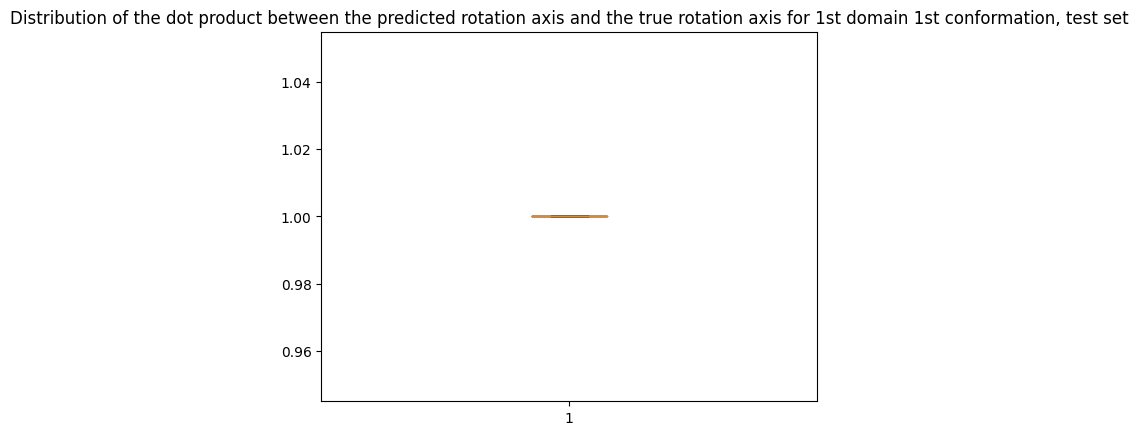

In [767]:
dot_prod = np.matmul(axis_test[:1000, 0, :], np.array([0.0, 0.0, 1.0]))
plt.boxplot(dot_prod, showfliers=False)
plt.title("Distribution of the dot product between the predicted rotation axis and the true rotation axis for 1st domain 1st conformation, test set")
plt.show()

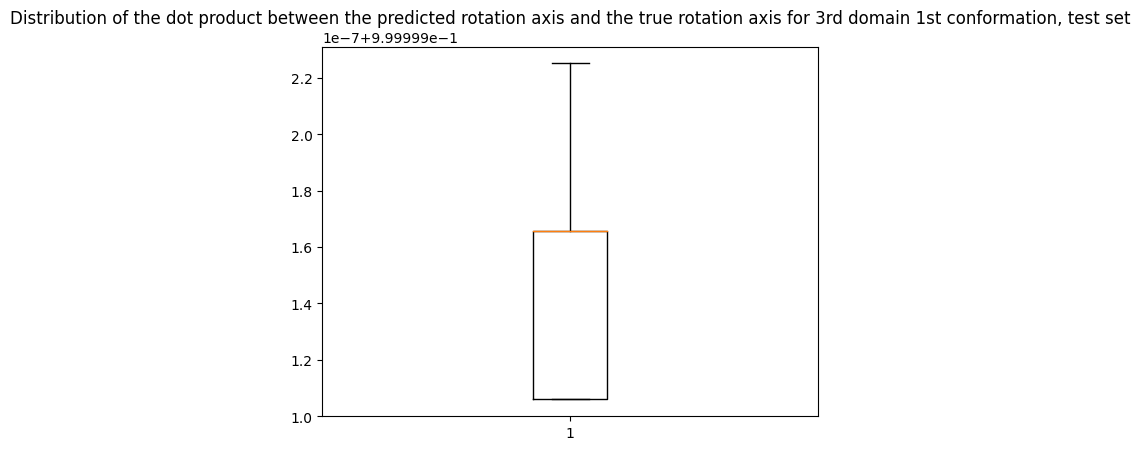

In [774]:
dot_prod = np.matmul(axis_test[:1000, 3, :], np.array([0.0, -1.0, 0.0]))
plt.boxplot(dot_prod, showfliers=False)
plt.title("Distribution of the dot product between the predicted rotation axis and the true rotation axis for 3rd domain 1st conformation, test set")
plt.show()

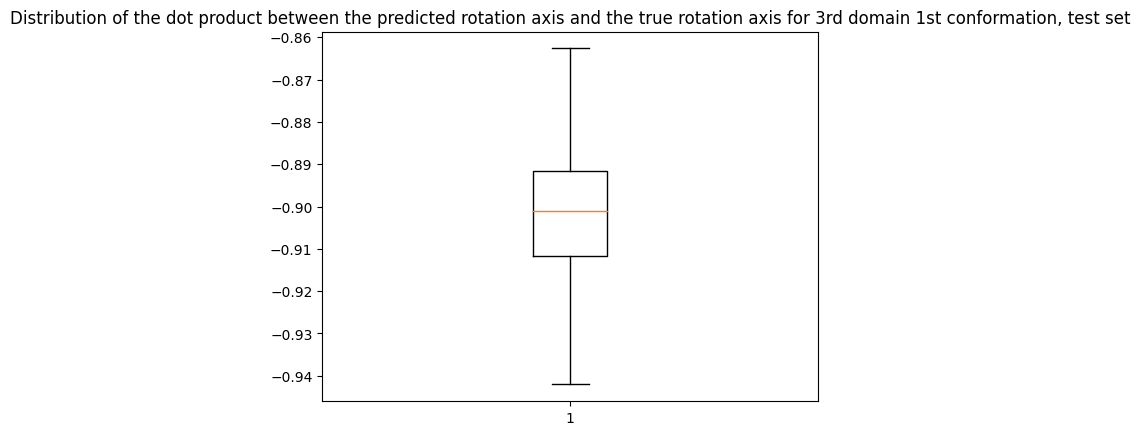

In [778]:
dot_prod = np.matmul(axis_test[1000:, 3, :], np.array([0.0, 1.0, 0.0]))
plt.boxplot(dot_prod, showfliers=False)
plt.title("Distribution of the dot product between the predicted rotation axis and the true rotation axis for 3rd domain 1st conformation, test set")
plt.show()

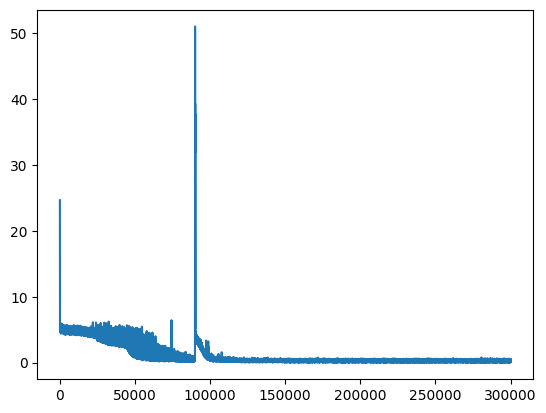

In [237]:
rmsd = np.load("data/vaeContinuous/losses_rmsd.npy")
plt.plot(rmsd)

In [241]:
mask_evol = mask_evolution("data/vaeContinuous/")

In [242]:
mask_evol

array([], dtype=float64)

In [239]:
end = 100000000
start = 0
plt.plot(mask_evol[start:end, 0], label="Domain 1", alpha=0.5)
plt.plot(mask_evol[start:end, 1], label="Domain 2", alpha=0.5)
plt.plot(mask_evol[start:end, 2], label="Domain 3", alpha=0.5)
plt.plot(mask_evol[start:end, 3], label="Domain 4", alpha=0.5)
plt.axhline(y=157, alpha=0.3, color="black")
plt.axhline(y=300, alpha=0.3, color="black")
plt.yticks([157, 300])
plt.legend(loc="upper left")
plt.title("Evolution of the number of residues in each domain")
plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [217]:
155*100

15500

In [233]:
rmsd[15400:15500]

array([414.5721 , 413.6224 , 413.62537, 414.60406, 415.8854 , 415.07928,
       413.31018, 412.35477, 412.63925, 414.58377, 414.2539 , 412.829  ,
       412.95508, 412.1148 , 416.01413, 413.899  , 415.22433, 413.22998,
       413.06662, 414.40555, 413.6281 , 415.58194, 414.17746, 413.86188,
       413.63156, 414.73874, 412.78586, 414.1248 , 413.632  , 416.0656 ,
       413.95297, 414.46906, 414.58218, 415.18723, 413.94907, 414.4706 ,
       414.24136, 416.00772, 414.5824 , 413.3143 , 412.5292 , 413.25266,
       414.15115, 413.18463, 414.51132, 412.7128 , 413.82874, 415.79578,
       414.15012, 415.2004 , 413.7421 , 415.6157 , 414.43246, 416.25937,
       413.85825, 414.2278 , 413.13657, 414.59097, 413.23547, 414.07916,
       413.9388 , 415.5766 , 414.82883, 415.45163, 415.1912 , 414.79718,
       414.2762 , 412.8404 , 412.62155, 415.15277, 414.48758, 413.64774,
       413.8528 , 416.3081 , 414.5752 , 414.32663, 414.5416 , 413.98203,
       415.26144, 413.66983, 414.94373, 414.29285, 

In [230]:
rmsd[:200800]

array([433.43073, 430.54053, 429.91284, ...,       nan,       nan,
             nan], dtype=float32)

In [227]:
len(rmsd)

300200

In [433]:
path = "data/vaeContinuousNoisy/"

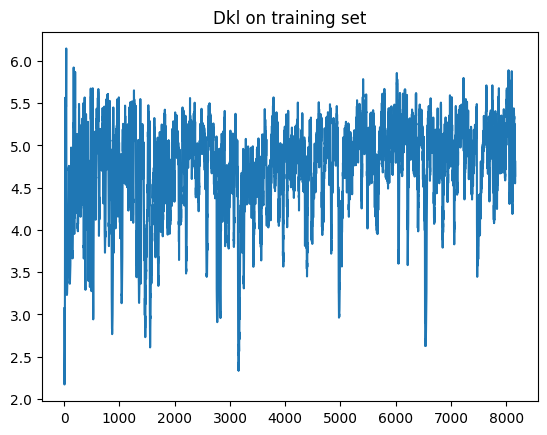

In [441]:
dkl = np.load(path + "losses_dkl.npy")
plt.plot(dkl[:92000])
plt.title("Dkl on training set")
plt.show()

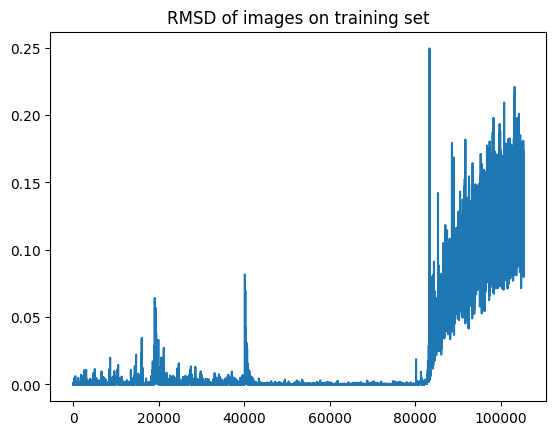

In [156]:
rmsd = np.load("data/vaeContinuousNoisyBatchSize1000Quater/losses_dkl.npy")
plt.plot(rmsd[150000:])
plt.title("RMSD of images on training set")
plt.show()

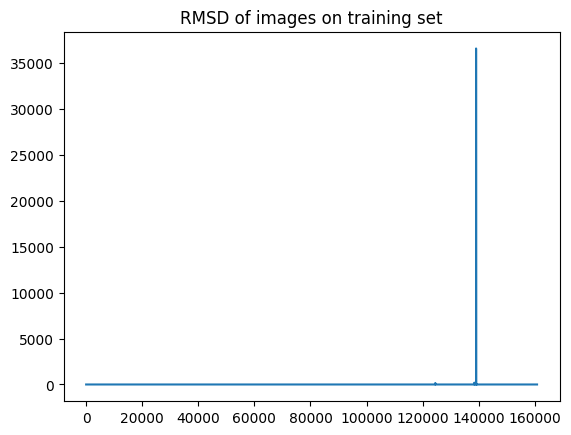

In [136]:
rmsd = np.load("data/vaeContinuousNoisyBatchSize1000Quater/losses_dkl.npy")
plt.plot(rmsd[:])
plt.title("RMSD of images on training set")
plt.show()

In [27]:
rmsd[-200:]

array([  2.5556657,   2.4638307,   2.575484 ,   2.5679698,   2.5678473,
         2.7351837,   2.5886798,   2.5344656,   2.575251 ,   2.5794876,
         2.528296 ,   2.6930351,   2.5745041, 516.8959   ,   2.5423195,
         2.58474  ,   2.669599 ,   2.499292 ,   2.5582592,   2.6095078,
         2.5106316,   2.4737878,   2.5515566,   2.474605 ,   2.5259945,
         2.6056037,   2.5853815,   2.5799353,   2.6279047,   2.457294 ,
         2.5699382,   2.5465744,   2.5808845,   2.6349416,   2.4929276,
         2.647215 ,   2.502806 ,   2.485003 ,   2.6156225,   2.5592585,
         2.4670527,   2.4364018,   2.5270815,   2.5098505,   2.5353203,
         2.3908706,   2.546099 ,   2.4104948,   2.4401724,   2.5027816,
         2.410353 ,   2.4484181,   2.5030172,   2.4291043,   2.4725392,
         2.5162761,   2.3266094,   2.4296303,   2.458082 ,   2.5166104,
         2.5437355,   2.4525084,   2.458307 ,   2.479435 ,   2.3897765,
         2.4672399,   2.4091573,   2.3441298,   2.3456452,   2.3

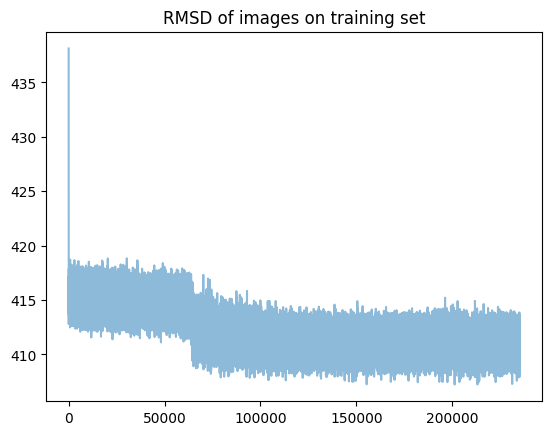

In [223]:
rmsdOld = np.load("data/vaeContinuousNoisyl2PenDeeperSaveNoise/losses_rmsd.npy")
rmsd = np.load("data/vaeContinuousNoisyZhongStyle/firstRun/losses_rmsd.npy")
start = 0
plt.plot(rmsd[start:], alpha=0.5)
#plt.plot(rmsdOld[start:], alpha=0.5)
plt.title("RMSD of images on training set")
plt.show()

In [217]:
len(rmsd)/100

221.0

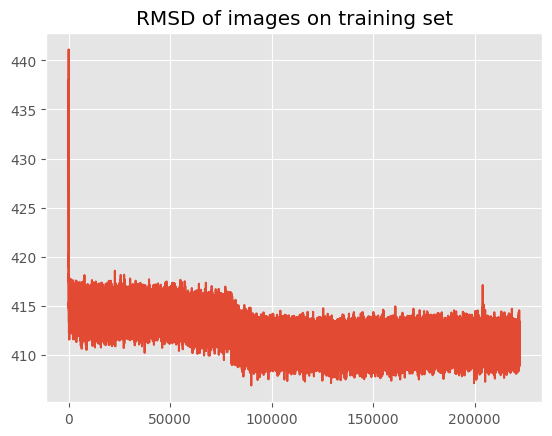

In [87]:
rmsdfirst = np.load("data/vaeContinuousNoisyl2PenDeeperSaveNoiseBatch500/firstRun/losses_rmsd.npy")
plt.plot(rmsdfirst[:])
plt.title("RMSD of images on training set")
plt.show()

In [139]:
len(rmsd)/100

1650.0

In [85]:
len(rmsd)

84700

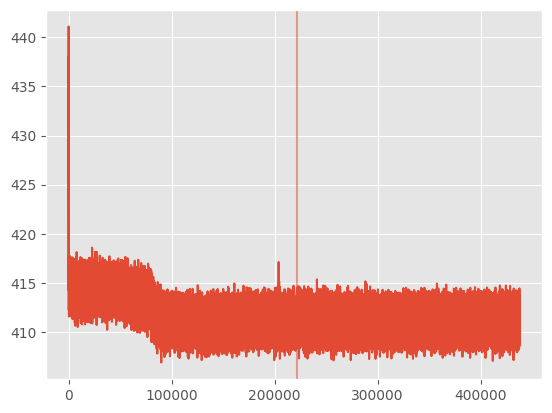

In [89]:
all_rmsd = np.concatenate([rmsdfirst, rmsd])
plt.plot(all_rmsd)
plt.axvline(222100, alpha=0.5)
plt.show()

In [68]:
len(rmsd)/100

2221.0

## Regular noisy

In [407]:
save_path = "data/presentationApril/regularNoisy/"

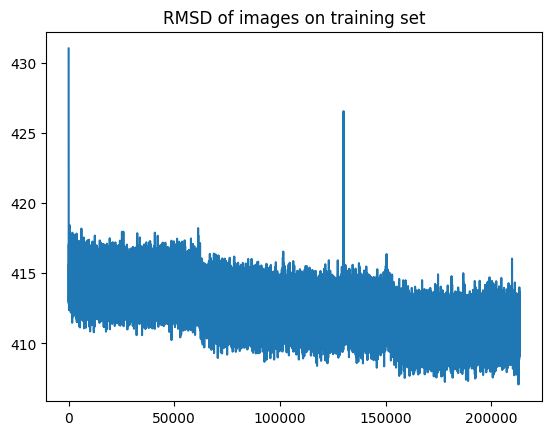

In [404]:
rmsdfirst = np.load("data/vaeContinuousNoisyl2PenDeeperSaveNoise/losses_rmsd.npy")
plt.plot(rmsdfirst[:])
plt.title("RMSD of images on training set")
plt.show()

In [385]:
mask_evol = mask_evolution("data/vaeContinuousNoisyl2PenDeeperSaveNoise/")

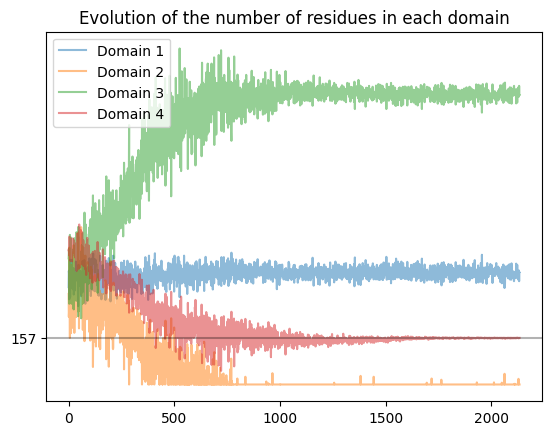

In [408]:
end = 50000
start = 0
plt.plot(mask_evol[start:end, 0], label="Domain 1", alpha=0.5)
plt.plot(mask_evol[start:end, 1], label="Domain 2", alpha=0.5)
plt.plot(mask_evol[start:end, 2], label="Domain 3", alpha=0.5)
plt.plot(mask_evol[start:end, 3], label="Domain 4", alpha=0.5)
#plt.plot(mask_evolOld[start:end, 3], label="Domain 4", alpha=0.5)
plt.axhline(y=157, alpha=0.3, color="black")
plt.yticks([157])
plt.legend(loc="upper left")
plt.title("Evolution of the number of residues in each domain")
plt.savefig(save_path + "mask_evol.png")
plt.show()

In [388]:
latent_distrib = np.load("data/vaeContinuousNoisyl2PenDeeperSaveNoise/latent_distrib.npy")
indexes = np.load("data/vaeContinuousNoisyl2PenDeeperSaveNoise/indexes.npy")
all_latent_distrib = np.concatenate(latent_distrib, axis= 0)
all_indexes = np.concatenate(indexes, axis= 0)

In [389]:
model = torch.load("data/vaeContinuousNoisyl2PenDeeperSaveNoise/full_model2123", map_location=torch.device('cpu'))
model.batch_size = 10000
model.device = "cpu"

In [390]:
translations_training, rotations_per_residue_training, axis_angle_domain_training = sample_structure(torch.tensor(all_latent_distrib[:, :1])
                                                                                                     , model)

In [393]:
path = "data/vaeContinuousNoisyl2PenDeeperSaveNoise/"
true_rot_mat_training = torch.load(path + "training_conformation_rotation_matrices.npy", 
                          map_location=torch.device('cpu'))
true_axis_angle_training = matrix_to_axis_angle(true_rot_mat_training)
true_angles_training = torch.sqrt(torch.sum(true_axis_angle_training[:, 2, :]**2, dim=-1))
true_axis_training = true_axis_angle_training[:, 3]/true_angles_training[:, None]
true_angles_training *= -1

In [394]:
#First we set the angle to the range [-pi, pi] and then we minus the angle because we change the axis
#from [0, -1, 0] to [0, 1, 0]
true_angles_training[true_angles_training < -np.pi] = -(true_angles_training[true_angles_training < -np.pi] + 2*np.pi)

In [395]:
torch.min(translations_training)

tensor(-0.2783, grad_fn=<MinBackward1>)

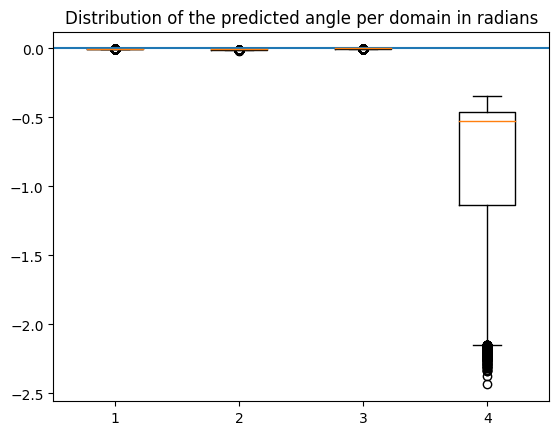

In [409]:
angle_training, axis_training = get_axis_and_angle(axis_angle_domain_training)
angle_training *= -1
axis_training *= -1
plt.boxplot(angle_training[:, :], showfliers=True)
#plt.axhline(y=-2.5)
plt.axhline(y=0)
plt.title("Distribution of the predicted angle per domain in radians")
plt.savefig(save_path + "domain_pred_angles.png")
plt.show()

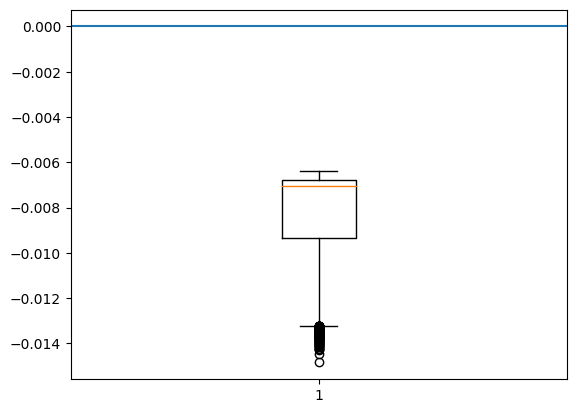

In [445]:
angle_training, axis_training = get_axis_and_angle(axis_angle_domain_training)
angle_training *= -1
axis_training *= -1
plt.boxplot(angle_training[:, 1], showfliers=True)
#plt.axhline(y=-2.5)
plt.axhline(y=0)
plt.show()

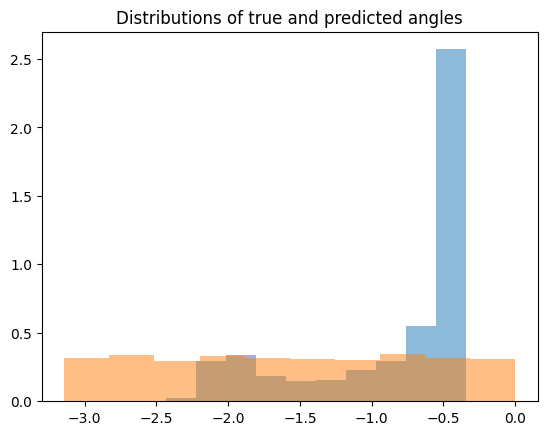

In [443]:
plt.hist(angle_training[:, 3], alpha=0.5,label="predicted", density=True)
plt.hist(true_angles_training, alpha=0.5, label="true", density=True)
plt.title("Distributions of true and predicted angles")
plt.savefig(save_path + "angle_histogram.png")
plt.show()

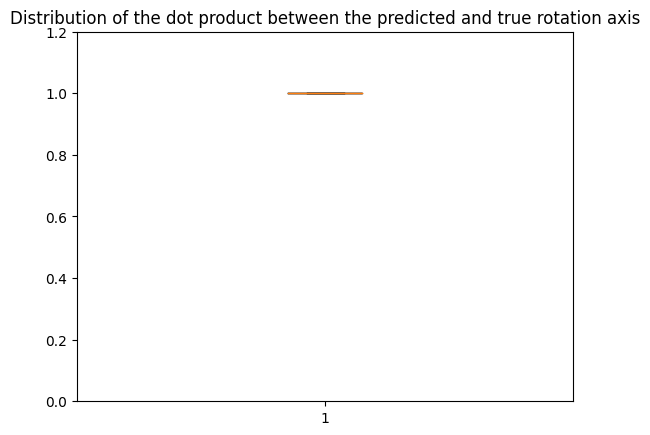

In [442]:
dot_prod_test = np.matmul(axis_training[:, 3, :], np.array([0.0, 1.0, 0.0]))
plt.boxplot(dot_prod_test, showfliers=True)
plt.ylim([0, 1.2])
plt.title("Distribution of the dot product between the predicted and true rotation axis")
plt.savefig(save_path + "boxplotRoationAxis.png")
plt.show()

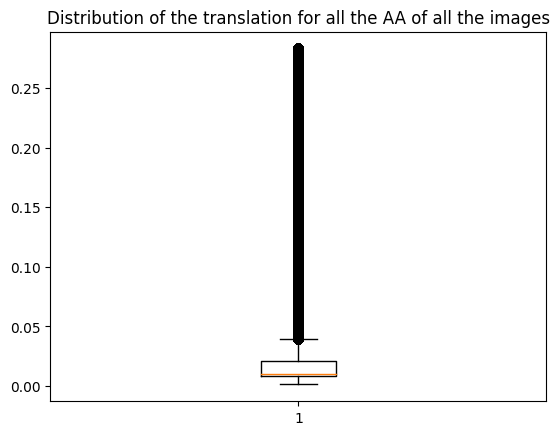

In [444]:
translations_magnitude_training = torch.sqrt(torch.sum(translations_training**2, dim=-1))
plt.boxplot(translations_magnitude_training.flatten().detach().numpy(), showfliers=True)
plt.title("Distribution of the translation for all the AA of all the images")
plt.savefig(save_path + "displacement.png")
plt.show()

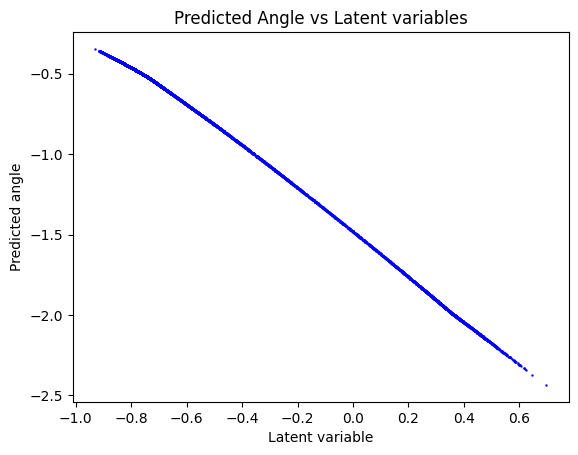

In [436]:
plt.scatter(all_latent_distrib[:, 0], angle_training[:, 3], s=0.5, color="blue")
plt.title("Predicted Angle vs Latent variables")
plt.xlabel("Latent variable")
plt.ylabel("Predicted angle")
plt.savefig(save_path + "predictedAngleVSLatentVar.png")
plt.show()

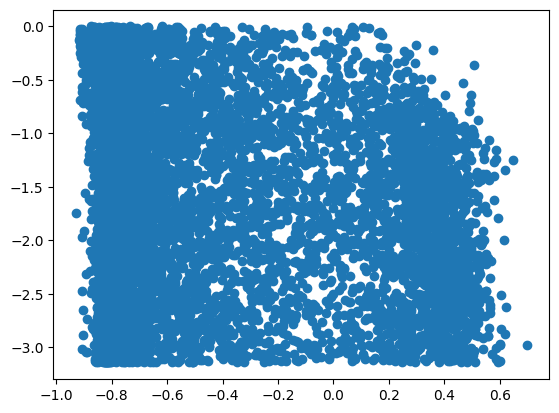

In [401]:
plt.scatter(all_latent_distrib[:, 0], true_angles_training)

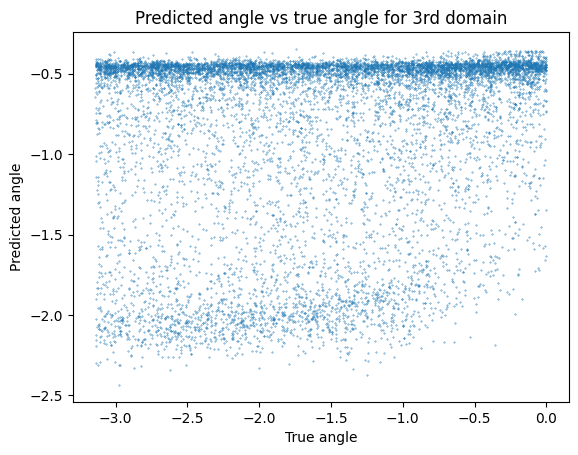

Correlation: [[1.         0.17683723]
 [0.17683723 1.        ]]


In [437]:
plt.scatter(true_angles_training, angle_training[:, 3], s=0.1)
plt.xlabel("True angle")
plt.ylabel("Predicted angle")
plt.title("Predicted angle vs true angle for 3rd domain")
plt.savefig(save_path + "predictedVsTrueAngle.png")
plt.show()
print("Correlation:", np.corrcoef(true_angles_training, angle_training[:, 3]))

## Zhong Style large scale mouvement

In [446]:
save_path = "data/presentationApril/ZhongS/"

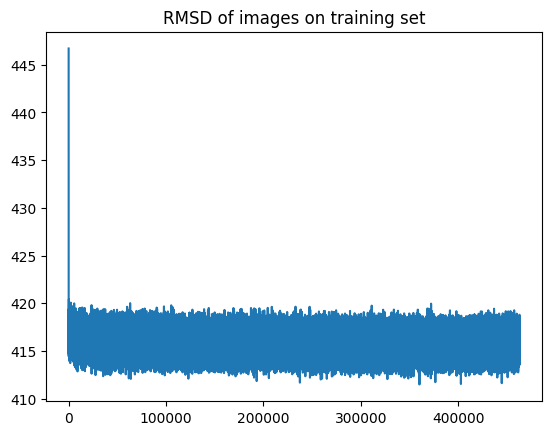

In [122]:
rmsdfirst = np.load("data/vaeContinuousNoisyZhongStyleNoCTF/losses_rmsd.npy")
rmsdSecond = np.load("data/vaeContinuousNoisyZhongStyleNoCTF/losses_rmsd_new.py")
plt.plot(np.concatenate([rmsdfirst, rmsdSecond]))
plt.title("RMSD of images on training set")
plt.show()

In [123]:
len(mask_evol)

4631

In [117]:
mask_evol = mask_evolution("data/vaeContinuousNoisyZhongStyleNoCTF/")

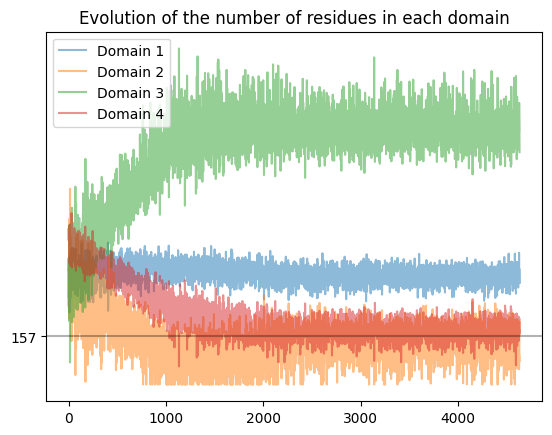

In [119]:
end = 50000
start = 0
plt.plot(mask_evol[start:end, 0], label="Domain 1", alpha=0.5)
plt.plot(mask_evol[start:end, 1], label="Domain 2", alpha=0.5)
plt.plot(mask_evol[start:end, 2], label="Domain 3", alpha=0.5)
plt.plot(mask_evol[start:end, 3], label="Domain 4", alpha=0.5)
#plt.plot(mask_evolOld[start:end, 3], label="Domain 4", alpha=0.5)
plt.axhline(y=157, alpha=0.3, color="black")
plt.yticks([157])
plt.legend(loc="upper left")
plt.title("Evolution of the number of residues in each domain")
#plt.savefig(save_path + "mask_evol.png")
plt.show()

In [124]:
len(mask_evol)

4631

In [138]:
latent_distrib = np.load("data/vaeContinuousNoisyZhongStyleNoCTF/latent_distrib.npy")
indexes = np.load("data/vaeContinuousNoisyZhongStyleNoCTF/indexes.npy")
all_latent_distrib = np.concatenate(latent_distrib, axis= 0)
all_indexes = np.concatenate(indexes, axis= 0)

In [139]:
model = torch.load("data/vaeContinuousNoisyZhongStyleNoCTF/full_model4630", map_location=torch.device('cpu'))
model.batch_size = 10000
model.device = "cpu"

In [140]:
translations_training, rotations_per_residue_training, axis_angle_domain_training = sample_structure(torch.tensor(all_latent_distrib[:, :1])
                                                                                                     , model)

In [111]:
path = "data/vaeContinuousNoisyZhongStyle2/"
#true_rot_mat_training = torch.load(path + "rotationPoseDataSet", 
#                          map_location=torch.device('cpu'))
#true_axis_angle_training = matrix_to_axis_angle(true_rot_mat_training)
#true_angles_training = torch.sqrt(torch.sum(true_axis_angle_training[:,:]**2, dim=-1))
#true_axis_training = true_axis_angle_training[:, :]/true_angles_training[:, None]
#true_angles_training *= -1

In [112]:
#First we set the angle to the range [-pi, pi] and then we minus the angle because we change the axis
#from [0, -1, 0] to [0, 1, 0]
true_angles_training[true_angles_training < -np.pi] = -(true_angles_training[true_angles_training < -np.pi] + 2*np.pi)

NameError: name 'true_angles_training' is not defined

In [95]:
translations_training.shape

torch.Size([10000, 1510, 3])

In [96]:
translations_magnitude_training[:, -157:].shape

torch.Size([10000, 157])

NameError: name 'save_path' is not defined

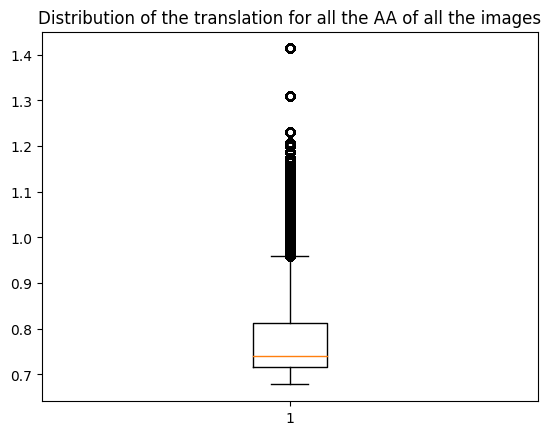

In [141]:
translations_magnitude_training = torch.sqrt(torch.sum(translations_training**2, dim=-1))
plt.boxplot(translations_magnitude_training[:, -157:].flatten().detach().numpy(), showfliers=True)
plt.title("Distribution of the translation for all the AA of all the images")
plt.savefig(save_path + "displacement.png")
plt.show()

In [142]:
axis_training[:, -1, 1]

array([-0.8616705 ,  0.8681355 ,  0.9048007 , ..., -0.89948004,
        0.94869334,  0.9948803 ], dtype=float32)

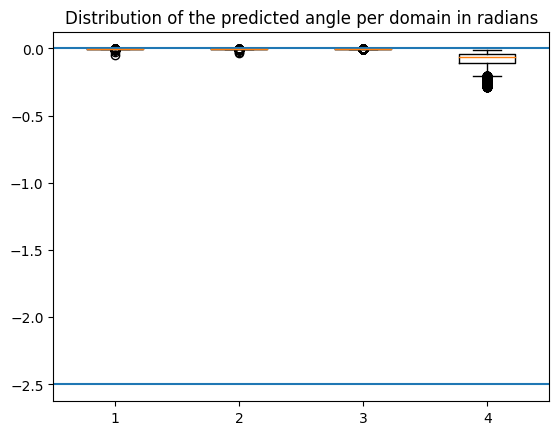

In [143]:
angle_training, axis_training = get_axis_and_angle(axis_angle_domain_training)
angle_training *= -1
axis_training *= -1
plt.boxplot(angle_training[:, :], showfliers=True)
plt.axhline(y=-2.5)
plt.axhline(y=0)
plt.title("Distribution of the predicted angle per domain in radians")
plt.show()

In [144]:
axis_training[:, -1, :]**2

array([[8.2756594e-02, 7.4247605e-01, 1.7476739e-01],
       [5.1872415e-04, 7.5365925e-01, 2.4582209e-01],
       [1.0570469e-02, 8.1866431e-01, 1.7076519e-01],
       ...,
       [8.4567137e-02, 8.0906433e-01, 1.0636846e-01],
       [6.7213067e-04, 9.0001905e-01, 9.9308871e-02],
       [2.6790069e-03, 9.8978686e-01, 7.5340644e-03]], dtype=float32)

NameError: name 'save_path' is not defined

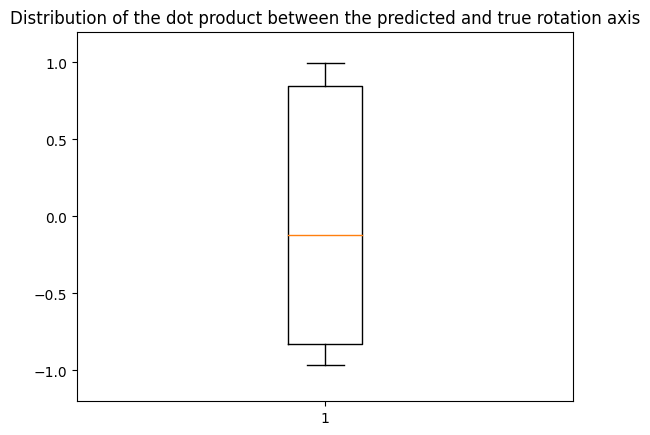

In [145]:
dot_prod_test = np.matmul(axis_training[:, -1, :], np.array([0.0, 1.0, 0.0]))
plt.boxplot(dot_prod_test, showfliers=True)
plt.ylim([-1.2, 1.2])
plt.title("Distribution of the dot product between the predicted and true rotation axis")
plt.savefig(save_path + "boxplotRoationAxis.png")
plt.show()

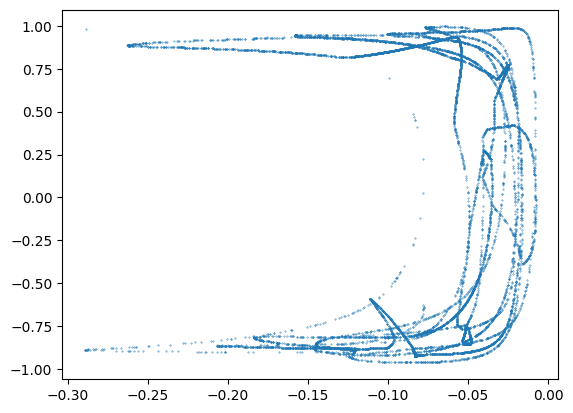

In [146]:
plt.scatter(angle_training[:, -1], dot_prod_test, s = 0.1)

In [150]:
old_angle_training == angle_training

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       ...,
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

Text(0.5, 1.0, 'Distribution of predicted angles')

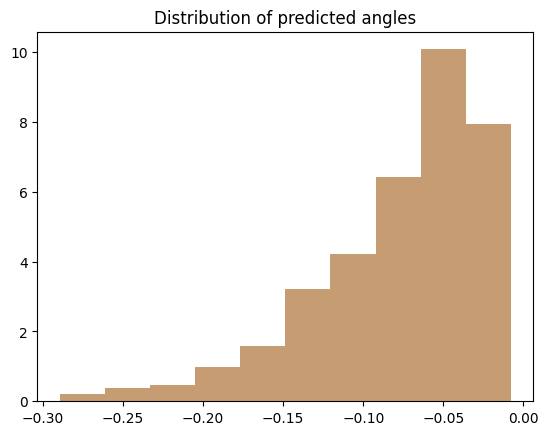

In [148]:
#structure_index = np.load("data/vaeContinuousNoisyZhongStyleNoCTF/structures_indexes.npy")
#true_angles = structure_index*0.25 + -2.5
plt.hist(angle_training[:, 3], alpha=0.5, density=True)
plt.hist(old_angle_training[:, 3], alpha=0.5, density=True)
#plt.hist(true_angles_training, alpha=0.5)
#for true_ang in true_angles:
#    plt.axvline(x=true_ang)

plt.title("Distribution of predicted angles")
#plt.savefig(save_path + "histo_predicted_angles.png")
#plt.axvline(x=-1.6)

In [113]:
angle_training == old_angle_training

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       ...,
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

In [137]:
#old_angle_training = angle_training

In [85]:
#old_angle_training = angle_training

In [84]:
#angle_training, axis_training = get_axis_and_angle(axis_angle_domain_training)
#angle_training *= -1
#axis_training *= -1
plt.boxplot(true_angles_training, showfliers=True)
plt.title("Distribution of the predicted angle per domain in radians")
plt.show()

NameError: name 'true_angles_training' is not defined

NameError: name 'save_path' is not defined

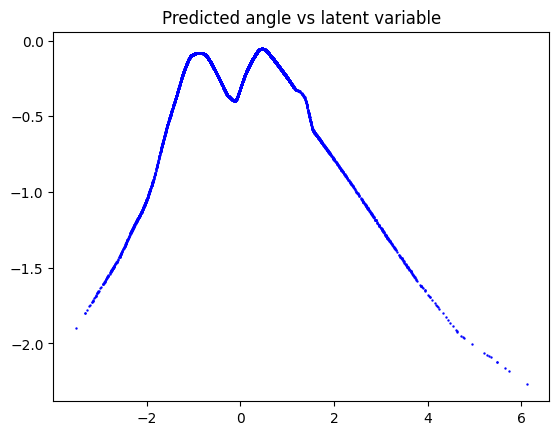

In [86]:
plt.scatter(all_latent_distrib[:, 0], angle_training[:, 3], s=0.5, color="blue")
plt.title("Predicted angle vs latent variable")
plt.savefig(save_path + "angleVSlatentVariable.png")
#plt.scatter(all_latent_distrib[-1000:, 0], angle_training[-1000:, 3], s=0.5, color="green")
#plt.scatter(all_latent_distrib[:, 0], angle_training[:, 3], s=0.5, color="red")

In [87]:
structure_index = np.load("data/vaeContinuousNoisyZhongStyle2/structures_indexes.npy")

NameError: name 'save_path' is not defined

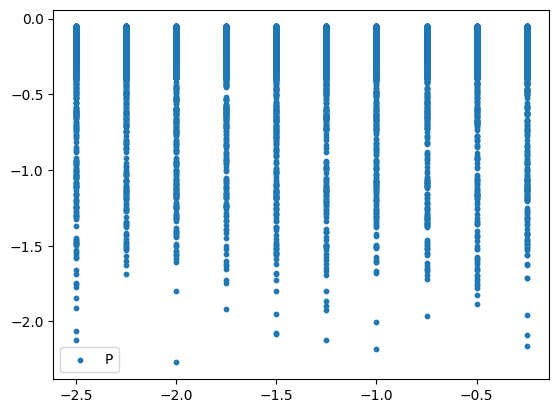

In [88]:
true_angles = structure_index*0.25 + -2.5
plt.scatter(np.repeat(true_angles, 1000), angle_training[:, -1], s=10)
plt.legend("Predicted vs true angle")
plt.savefig(save_path + "predVStrueAngle.png")
plt.show()

In [382]:
np.repeat(true_angles, 1000).shape

(10000,)

In [383]:
angle_training.shape

(10000, 4)

(array([ 982., 1071.,  986., 1024.,  962.,  974., 1006.,  987., 1038.,
         970.]),
 array([-3.14111710e+00, -2.82706285e+00, -2.51300883e+00, -2.19895458e+00,
        -1.88490045e+00, -1.57084632e+00, -1.25679207e+00, -9.42737937e-01,
        -6.28683805e-01, -3.14629614e-01, -5.75464743e-04]),
 <BarContainer object of 10 artists>)

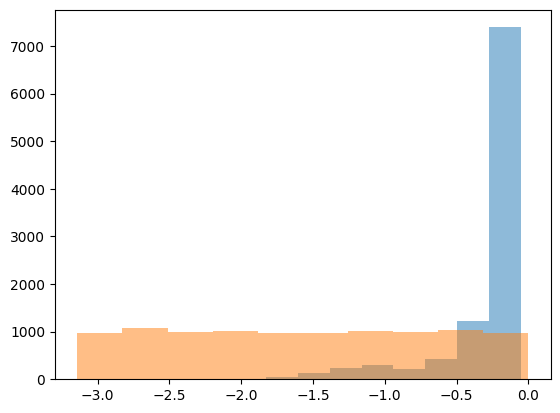

In [375]:
plt.hist(angle_training[:, 3], alpha=0.5)
plt.hist(true_angles_training, alpha=0.5)

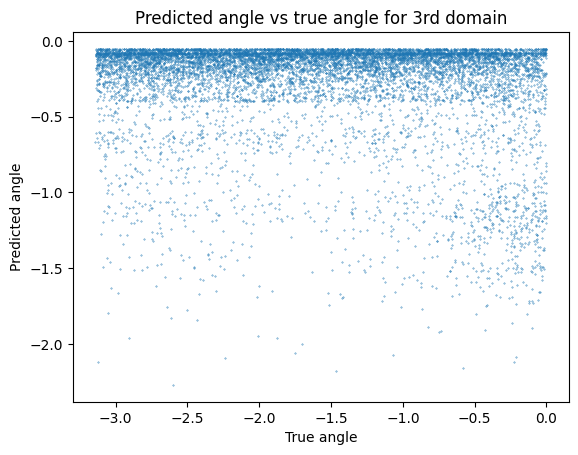

Correlation: [[ 1.         -0.16200636]
 [-0.16200636  1.        ]]


In [476]:
plt.scatter(true_angles_training, angle_training[:, 3], s=0.1)
plt.xlabel("True angle")
plt.ylabel("Predicted angle")
plt.title("Predicted angle vs true angle for 3rd domain")
plt.show()
print("Correlation:", np.corrcoef(true_angles_training, angle_training[:, 3]))

In [530]:
rotations_per_residue_np = rotations_per_residue_training.detach().numpy()
translations_np = translations_training.detach().numpy()
features = np.load("data/features.npy", allow_pickle=True)
features = features.item()
local_frame = features["local_frame"]

In [547]:
rotations_per_residue_np[846, -157:]

array([[[ 0.6080695 ,  0.15180002,  0.7792357 ],
        [-0.00262728,  0.9819282 , -0.18923557],
        [-0.79387945,  0.11302108,  0.5974793 ]],

       [[ 0.21321638,  0.24649392,  0.9453991 ],
        [ 0.05347836,  0.96325505, -0.2632105 ],
        [-0.9755402 ,  0.10667914,  0.19219969]],

       [[-0.12277818,  0.31172258,  0.94220734],
        [ 0.11607612,  0.9473846 , -0.2983097 ],
        [-0.9856226 ,  0.07274187, -0.15250175]],

       ...,

       [[-0.46945477,  0.36456925,  0.80417764],
        [ 0.19436587,  0.9311064 , -0.3086467 ],
        [-0.8612981 ,  0.01140905, -0.5079721 ]],

       [[-0.46945477,  0.36456925,  0.80417764],
        [ 0.19436587,  0.9311064 , -0.3086467 ],
        [-0.8612981 ,  0.01140905, -0.5079721 ]],

       [[-0.46945477,  0.36456925,  0.80417764],
        [ 0.19436587,  0.9311064 , -0.3086467 ],
        [-0.8612981 ,  0.01140905, -0.5079721 ]]], dtype=float32)

In [531]:
pdb_parser = PDBParser()
io = PDBIO()
for i in range(0, 10000):
    if i%100 == 0:
        print(i)
        
    struct = pdb_parser.get_structure("A", "data/vaeContinuous/ranked_0.pdb")
    protein.main.rotate_residues(struct, rotations_per_residue_np[i], local_frame)
    protein.main.translate_residues(struct, translations_np[i])
    io.set_structure(struct)
    io.save("data/vaeContinuousNoisyZhongStyle2/deformedStructures/predicted"+str(i)+".pdb", preserve_atom_numbering = True)
    

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500


KeyboardInterrupt: 

In [538]:
np.argmax(angle_training[:1000, -1])

846

In [539]:
np.max(angle_training[:1000, -1])

2.1213512

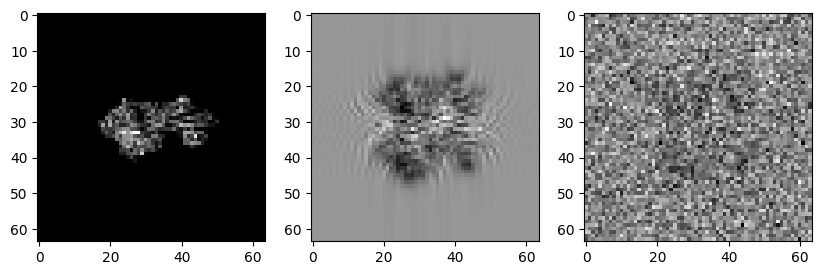

In [551]:
ctf_image = np.load("data/ctf_corrupted.npy")
no_ctf_image = np.load("data/no_ctf_corrupted.npy")
fig, axs = plt.subplots(1,3, figsize=(10, 10))
axs[0].imshow(no_ctf_image, cmap="gray")
axs[1].imshow(ctf_image, cmap="gray")
axs[2].imshow(ctf_image + np.sqrt(0.2)*np.random.normal(size=(64, 64)), cmap="gray")
plt.savefig(save_path + "/protein.png")
plt.show()

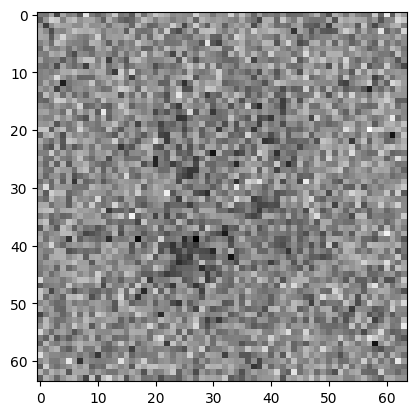

In [552]:
ctf_image = np.load("data/ctf_corrupted.npy")
plt.imshow(ctf_image + np.sqrt(0.2)*np.random.normal(size=(64, 64)), cmap="gray")
plt.savefig(save_path + "/protein.png")
plt.show()

In [544]:
translations_training[846, -157:]

tensor([[ 0.4525, -0.3893,  1.4199],
        [ 0.6773, -0.5695,  2.0909],
        [ 0.8521, -0.7096,  2.6126],
        [ 0.9546, -0.7918,  2.9186],
        [ 1.0051, -0.8322,  3.0692],
        [ 1.0278, -0.8504,  3.1370],
        [ 1.0376, -0.8583,  3.1662],
        [ 1.0418, -0.8616,  3.1786],
        [ 1.0435, -0.8630,  3.1839],
        [ 1.0443, -0.8636,  3.1860],
        [ 1.0446, -0.8638,  3.1870],
        [ 1.0447, -0.8639,  3.1873],
        [ 1.0448, -0.8640,  3.1875],
        [ 1.0448, -0.8640,  3.1876],
        [ 1.0448, -0.8640,  3.1876],
        [ 1.0448, -0.8640,  3.1876],
        [ 1.0448, -0.8640,  3.1876],
        [ 1.0448, -0.8640,  3.1876],
        [ 1.0448, -0.8640,  3.1876],
        [ 1.0448, -0.8640,  3.1876],
        [ 1.0448, -0.8640,  3.1876],
        [ 1.0448, -0.8640,  3.1876],
        [ 1.0448, -0.8640,  3.1876],
        [ 1.0448, -0.8640,  3.1876],
        [ 1.0448, -0.8640,  3.1876],
        [ 1.0448, -0.8640,  3.1876],
        [ 1.0448, -0.8640,  3.1876],
 

In [144]:
model = torch.load("data/vaeContinuousNoisy/full_model", map_location=torch.device('cpu'))

In [146]:
model.cluster_means_mean

Parameter containing:
tensor([[nan, nan, nan, nan]], requires_grad=True)

In [147]:
model.cluster_means_std

Parameter containing:
tensor([[nan, nan, nan, nan]], requires_grad=True)

In [148]:
model.cluster_std_std

Parameter containing:
tensor([[nan, nan, nan, nan]], requires_grad=True)

In [149]:
model.cluster_proportions_mean

Parameter containing:
tensor([[nan, nan, nan, nan]], requires_grad=True)

In [233]:
model = torch.load("data/vaeContinuousNoisyBatchSize1000/full_model183", map_location=torch.device('cpu'))

In [234]:
model.encoder

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (input_layer): Sequential(
    (0): Linear(in_features=4096, out_features=2048, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (output_layer): Sequential(
    (0): Linear(in_features=512, out_features=2, bias=True)
  )
  (linear_relu_stack): Sequential(
    (0): Sequential(
      (0): Linear(in_features=2048, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
  )
)

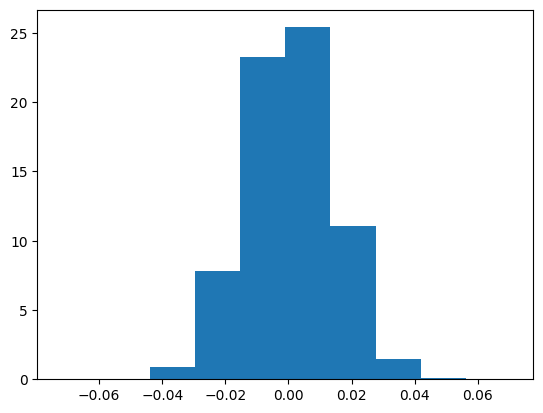

In [255]:
plt.hist(model.encoder.input_layer[0].weight.detach().numpy().flatten(), density=True)
plt.show()

In [257]:
np.mean(model.encoder.input_layer[0].weight.detach().numpy().flatten())

0.0005643836

In [259]:
for lay in model.encoder.linear_relu_stack:
    print(torch.mean(lay[0].weight))
    print(torch.std(lay[0].weight))
    print("\n")

tensor(-0.0022, grad_fn=<MeanBackward0>)
tensor(0.0145, grad_fn=<StdBackward0>)


tensor(-0.0009, grad_fn=<MeanBackward0>)
tensor(0.0194, grad_fn=<StdBackward0>)


tensor(-0.0013, grad_fn=<MeanBackward0>)
tensor(0.0265, grad_fn=<StdBackward0>)




In [252]:
torch.mean(model.encoder.output_layer[0].weight)

tensor(-0.0005, grad_fn=<MeanBackward0>)

In [266]:
ls data/vae2ConformationsNoisyBatchSize1000/

ls: data/vae2ConformationsNoisyBatchSize1000/: No such file or directory


In [270]:
ls data/vaeContinuousNoisyBatchSize1000


full_model183
losses_cluster_mean.npy
losses_cluster_proportions.npy
losses_cluster_std.npy
losses_dkl.npy
losses_rmsd.npy
losses_train.npy
mask0.npy
mask1.npy
mask10.npy
mask100.npy
mask101.npy
mask102.npy
mask103.npy
mask104.npy
mask105.npy
mask106.npy
mask107.npy
mask108.npy
mask109.npy
mask11.npy
mask110.npy
mask111.npy
mask112.npy
mask113.npy
mask114.npy
mask115.npy
mask116.npy
mask117.npy
mask118.npy
mask119.npy
mask12.npy
mask120.npy
mask121.npy
mask122.npy
mask123.npy
mask124.npy
mask125.npy
mask126.npy
mask127.npy
mask128.npy
mask129.npy
mask13.npy
mask130.npy
mask131.npy
mask132.npy
mask133.npy
mask134.npy
mask135.npy
mask136.npy
mask137.npy
mask138.npy
mask139.npy
mask14.npy
mask140.npy
mask141.npy
mask142.npy
mask143.npy
mask144.npy
mask145.npy
mask146.npy
mask147.npy
mask148.npy
mask149.npy
mask15.npy
mask150.npy
mask151.npy
mask152.npy
mask153.npy
mask154.npy
mask155.npy
mask156.npy
mask157.npy
mask158.npy
mask159.npy
mask16.npy
mask160.npy
mask161.npy
mask162.npy
mask163

In [290]:
dataset_path="data/vaeContinuousNoisyBatchSize1000/"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 100
#This represent the number of true domains
N_domains = 3
N_pixels = 64*64
#This represents the number of domain we think there are
N_input_domains = 4
latent_dim = 9
num_nodes = 1510
cutoff1 = 300
cutoff2 = 1353
K_nearest_neighbors = 30
num_edges = num_nodes*K_nearest_neighbors
#B = 10
B = 100
S = 1
dataset_size = 10000
test_set_size = int(dataset_size/10)

graph_file="data/features.npy"
features = np.load(graph_file, allow_pickle=True)
features = features.item()
absolute_positions = torch.tensor(features["absolute_positions"] - np.mean(features["absolute_positions"], axis=0))
absolute_positions = absolute_positions.to(device)
local_frame = torch.tensor(features["local_frame"])
local_frame = local_frame.to(device)
relative_positions = torch.matmul(absolute_positions, local_frame)
pixels_x = np.linspace(-150, 150, num=64).reshape(1, -1)
pixels_y = np.linspace(-150, 150, num=64).reshape(1, -1)
renderer = Renderer(pixels_x, pixels_y, std=1, device=device)
model_path = "data/vaeContinuousNoisyBatchSize1000/full_model183"
model = torch.load(model_path, map_location=torch.device(device))



training_set = torch.load(dataset_path + "training_set.npy", map_location=torch.device(device)).to(device)
training_rotations_angles = torch.load(dataset_path + "training_rotations_angles.npy", map_location=torch.device(device)).to(device)
training_rotations_axis = torch.load(dataset_path + "training_rotations_axis.npy", map_location=torch.device(device)).to(device)
training_rotations_matrices = torch.load(dataset_path + "training_rotations_matrices.npy", map_location=torch.device(device)).to(device)
training_conformation_rotation_matrix = torch.load(dataset_path + "training_conformation_rotation_matrices.npy", map_location=torch.device(device))
generated_noise = torch.randn(size=(10000, 64,64))*np.sqrt(0.2)
print("SHOULD WE USE ENCODER:", model.use_encoder)
training_indexes = torch.tensor(np.array(range(10000)))
all_latent_distrib = []
all_indexes = []
for epoch in range(0, 1):
    epoch_loss = torch.empty(1)
    # data_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True)
    data_loader = iter(DataLoader(training_indexes, batch_size=batch_size, shuffle=False))
    for i in range(100):
        start = time.time()
        print("epoch:", epoch)
        print(i / 100)
        # batch_data = next(iter(data_loader))
        batch_indexes = next(data_loader)
        #print(batch_indexes)
        ##Getting the batch translations, rotations and corresponding rotation matrices
        batch_data = training_set[batch_indexes]
        batch_rotations_angles = training_rotations_angles[batch_indexes]
        batch_rotations_axis = training_rotations_axis[batch_indexes]
        batch_rotation_matrices = training_rotations_matrices[batch_indexes]
        batch_data_for_deform = torch.reshape(batch_data, (batch_size, N_input_domains, 3))
        batch_conformation_rotation_matrices = training_conformation_rotation_matrix[batch_indexes]
        ## Deforming the structure for each batch data point
        deformed_structures = utils.deform_structure(absolute_positions, cutoff1, cutoff2, batch_data_for_deform,
                                                     batch_conformation_rotation_matrices, local_frame,
                                                     relative_positions,
                                                     1510, device)

        print("Deformed")
        ## We then rotate the structure and project them on the x-y plane.
        deformed_images = renderer.compute_x_y_values_all_atoms(deformed_structures, batch_rotation_matrices)
        deformed_images += generated_noise[batch_indexes]
        latent_distrib = model.encode(deformed_images)
        latent_mean = latent_distrib[:, :1]
        latent_std = latent_distrib[:, 1:]
        minus_batch_Dkl_loss = 0.5 * torch.sum(1 + torch.log(latent_std ** 2) \
                                                   - latent_mean ** 2 \
                                                   - latent_std ** 2, dim=1)
        dklss = torch.mean(minus_batch_Dkl_loss)
        print(dklss)
        all_latent_distrib.append(latent_distrib.detach().numpy())
        all_indexes.append(batch_indexes.detach().numpy())


np.save(dataset_path + "latent_distrib.npy", np.array(all_latent_distrib))
np.save(dataset_path + "indexes.npy", np.array(all_indexes))

/Users/gabdu45/PycharmProjects/segmentationCryoEM/imageRenderer.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ctf = torch.sqrt(torch.tensor(1 - w ** 2, device=self.device)) * torch.sin(torch.tensor(gamma, device=self.device))\
/Users/gabdu45/PycharmProjects/segmentationCryoEM/imageRenderer.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  - w * torch.cos(torch.tensor(gamma, device=self.device))


SHOULD WE USE ENCODER: True
epoch: 0
0.0
Deformed
tensor(-6.0945, grad_fn=<MeanBackward0>)
epoch: 0
0.01
Deformed
tensor(-5.9002, grad_fn=<MeanBackward0>)
epoch: 0
0.02
Deformed
tensor(-5.9119, grad_fn=<MeanBackward0>)
epoch: 0
0.03
Deformed
tensor(-5.8520, grad_fn=<MeanBackward0>)
epoch: 0
0.04
Deformed
tensor(-5.8574, grad_fn=<MeanBackward0>)
epoch: 0
0.05
Deformed
tensor(-5.9540, grad_fn=<MeanBackward0>)
epoch: 0
0.06
Deformed
tensor(-6.0762, grad_fn=<MeanBackward0>)
epoch: 0
0.07
Deformed
tensor(-5.9410, grad_fn=<MeanBackward0>)
epoch: 0
0.08
Deformed
tensor(-5.9706, grad_fn=<MeanBackward0>)
epoch: 0
0.09
Deformed
tensor(-5.8730, grad_fn=<MeanBackward0>)
epoch: 0
0.1
Deformed
tensor(-5.7602, grad_fn=<MeanBackward0>)
epoch: 0
0.11
Deformed
tensor(-6.0137, grad_fn=<MeanBackward0>)
epoch: 0
0.12
Deformed
tensor(-5.9917, grad_fn=<MeanBackward0>)
epoch: 0
0.13
Deformed
tensor(-5.9354, grad_fn=<MeanBackward0>)
epoch: 0
0.14
Deformed
tensor(-5.6627, grad_fn=<MeanBackward0>)
epoch: 0
0.15


In [276]:
from torch.utils.data import DataLoader

In [278]:
import time

In [280]:
import utils

In [286]:
torch.log(torch.ones(1)*0.0001**2)

tensor([-18.4207])

In [22]:
np.sqrt(8.3977e-05)

0.00916389655114024

In [248]:
images = torch.load("data/vaeContinuousNoisyZhongStyle/firstRun/continuousConformationDataSet")

In [249]:
images.shape

torch.Size([10000, 64, 64])

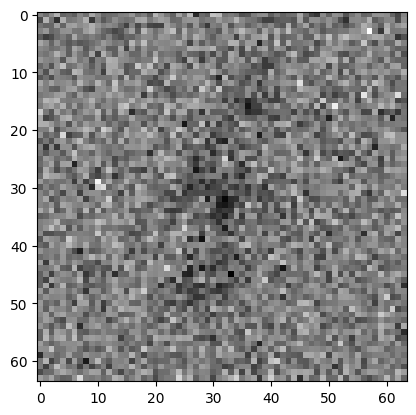

In [548]:
plt.imshow(images[901], cmap="gray")
plt.savefig(save_path)

In [106]:
images

tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        [[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        [[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        ...,

        [[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]

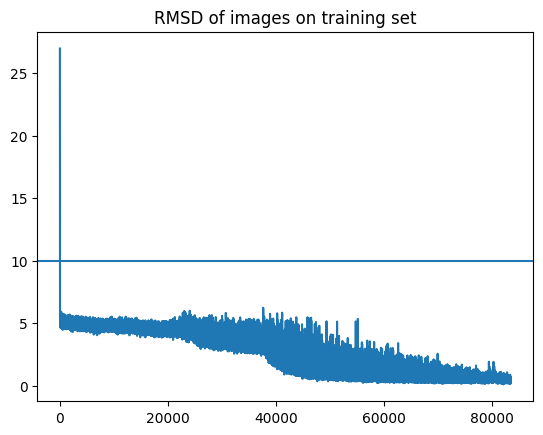

In [52]:
#rmsdOld = np.load("data/vaeContinuousNoisyl2PenDeeperSaveNoise/losses_rmsd.npy")
rmsd = np.load("data/vaeContinuous/losses_rmsd.npy")
#rmsd_new = np.load("data/vaeContinuousNoisyZhongStyle2/losses_rmsd.npy")
start = 0
plt.plot(np.concatenate([rmsd[start:10000000]]))#, rmsd_new]), alpha=0.5)
#plt.axhline(y=415)
#plt.plot(rmsdOld[start:], alpha=0.5)
plt.axhline(y=10)
plt.title("RMSD of images on training set")
plt.show()

In [56]:
80000/100

800.0

In [11]:
50000/100

500.0

In [54]:
#mask_evolOld = mask_evolution("data/vaeContinuousNoisyl2PenDeeperSaveNoise/")
mask_evol = mask_evolution("data/vaeContinuous/")

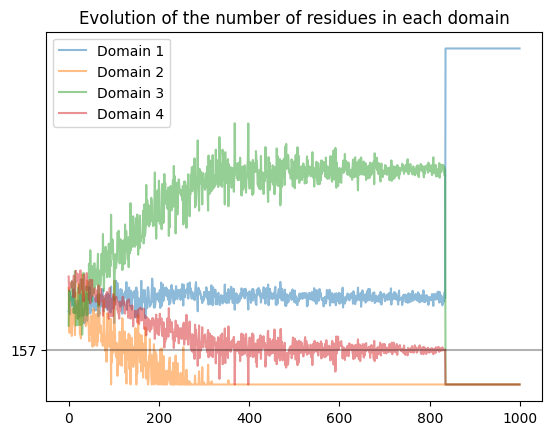

In [55]:
end = 1000
start = 0
plt.plot(mask_evol[start:end, 0], label="Domain 1", alpha=0.5)
plt.plot(mask_evol[start:end, 1], label="Domain 2", alpha=0.5)
plt.plot(mask_evol[start:end, 2], label="Domain 3", alpha=0.5)
plt.plot(mask_evol[start:end, 3], label="Domain 4", alpha=0.5)
#plt.plot(mask_evolOld[start:end, 3], label="Domain 4", alpha=0.5)
plt.axhline(y=157, alpha=0.3, color="black")
plt.yticks([157])
plt.legend(loc="upper left")
plt.title("Evolution of the number of residues in each domain")
plt.show()

In [20]:
len(mask_evol)

2286

In [ ]:
#Zhong style 2 is large scale mvmt
#Zhong style 1 is same but small scale
#Zhong style 3 is large scale with small batch size

In [12]:
data = torch.load("data/vaeContinuousNoisyZhongStyleNoCTF/continuousConformationDataSet")

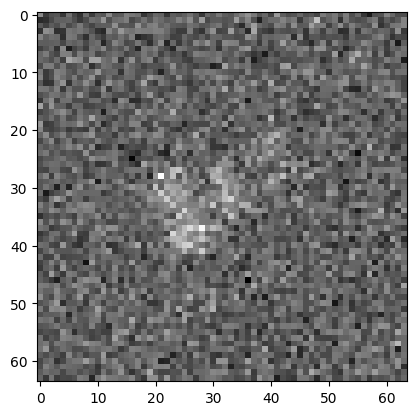

In [17]:
plt.imshow(data[1005], cmap="gray")

In [151]:
5923/600

9.871666666666666

In [156]:
np.linspace(0, 1, 10000)

array([0.00000000e+00, 1.00010001e-04, 2.00020002e-04, ...,
       9.99799980e-01, 9.99899990e-01, 1.00000000e+00])

In [163]:
5*np.exp(-7*9.99899990e-01)

0.004562602851350312

In [164]:
(5*np.exp(-7*9.99899990e-01))**2

2.0817344779149997e-05

In [174]:
a = 1
b = -7

In [175]:
def int_sigma_sq_t(t0, t):
    return - a**2/(2*b) * (np.exp(-2*b*t) - np.exp(-2*b*t0))

In [176]:
int_sigma_sq_t(0, 1) - int_sigma_sq_t(0, 9.99899990e-01)

120.18829460533743

In [177]:
int_sigma_sq_t(0, 1)

85900.23458319834

In [178]:
int_sigma_sq_t(0, 9.99899990e-01)

85780.046288593

In [2]:
import torch

In [72]:
a = torch.load("data/vaeContinuousNew/continuousConformationDataSet")

In [18]:
a.shape

torch.Size([10000, 64, 64])

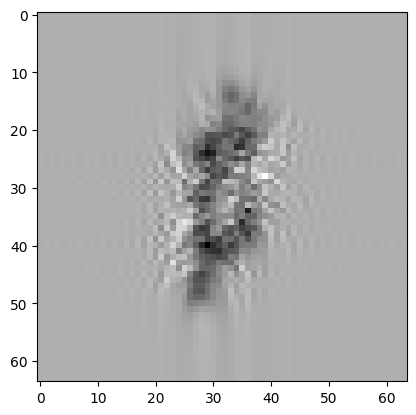

In [73]:
plt.imshow(a[1050], cmap="gray")

In [70]:
ls data/vaeContinuousNew/

In [85]:
20*np.exp(-3*2)

0.04957504353332717

In [10]:
mask_evol = mask_evolution("data/vaeContinuousNoisyNoCTF/")

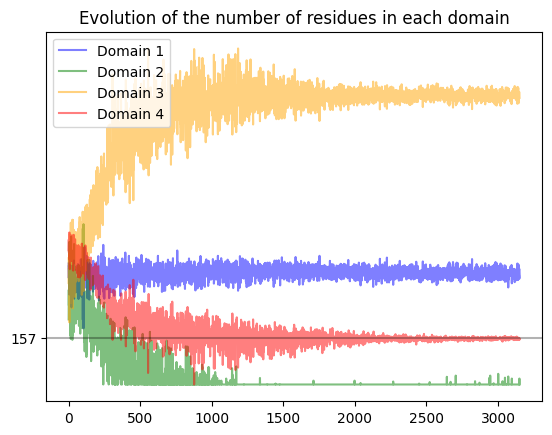

In [11]:
plt.plot(mask_evol[:, 0], label="Domain 1", alpha=0.5, color="blue")
plt.plot(mask_evol[:, 1], label="Domain 2", alpha=0.5, color="green")
plt.plot(mask_evol[:, 2], label="Domain 3", alpha=0.5, color="orange")
plt.plot(mask_evol[:, 3], label="Domain 4", alpha=0.5, color="red")
plt.axhline(y=157, alpha=0.3, color="black")
plt.yticks([157])
plt.legend(loc="upper left")
plt.title("Evolution of the number of residues in each domain")
plt.show()

In [30]:
mask_evol.shape

(3152, 4)

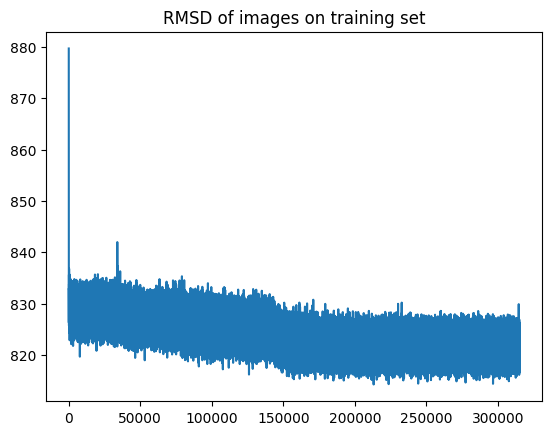

In [9]:
rmsd = np.load("data/vaeContinuousNoisyNoCTF/losses_rmsd.npy")
plt.plot(rmsd[:10000000])
plt.title("RMSD of images on training set")
plt.show()

In [20]:
latent_distrib = np.load("data/vaeContinuousNoisyNoCTF/latent_distrib.npy")
indexes = np.load("data/vaeContinuousNoisyNoCTF/indexes.npy")
all_latent_distrib = np.concatenate(latent_distrib, axis= 0)
all_indexes = np.concatenate(indexes, axis= 0)

In [21]:
model = torch.load("data/vaeContinuousNoisyNoCTF/full_model", map_location=torch.device('cpu'))
model.batch_size = 10000
model.device = "cpu"

In [22]:
translations_training, rotations_per_residue_training, axis_angle_domain_training = sample_structure(torch.tensor(all_latent_distrib[:, :1])
                                                                                                     , model)

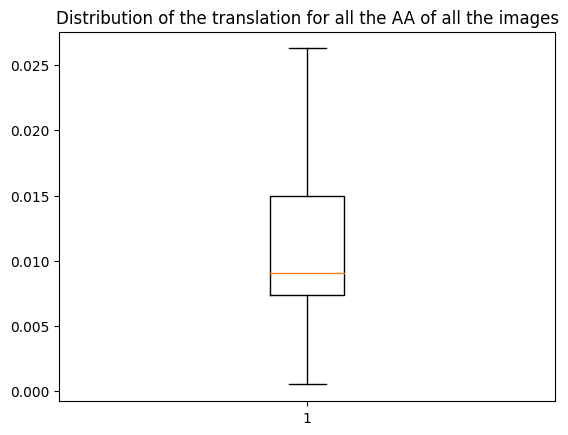

In [23]:
translations_magnitude_training = torch.sqrt(torch.sum(translations_training**2, dim=-1))
plt.boxplot(translations_magnitude_training.flatten().detach().numpy(), showfliers=False)
plt.title("Distribution of the translation for all the AA of all the images")
#plt.savefig("data/meetingSebastian16032023/continuous/displacement.png")
plt.show()

In [25]:
path = "data/vaeContinuousNoisyNoCTF/"
true_rot_mat_training = torch.load(path + "training_conformation_rotation_matrices", 
                          map_location=torch.device('cpu'))
true_axis_angle_training = matrix_to_axis_angle(true_rot_mat_training)
true_angles_training = torch.sqrt(torch.sum(true_axis_angle_training[:, 2, :]**2, dim=-1))
true_axis_training = true_axis_angle_training[:, 3]/true_angles_training[:, None]
true_angles_training *= -1

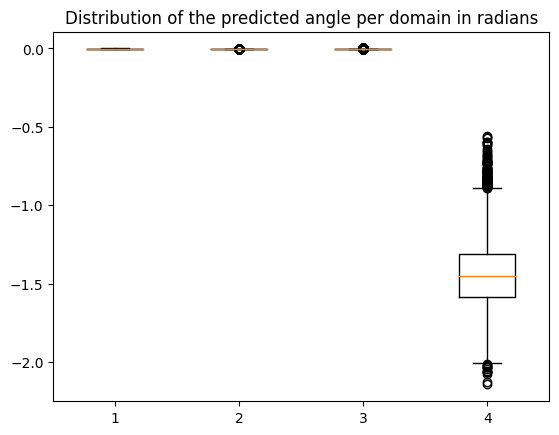

In [27]:
angle_training, axis_training = get_axis_and_angle(axis_angle_domain_training)
angle_training *= -1
axis_training *= -1
plt.boxplot(angle_training[:, :], showfliers=True)
plt.title("Distribution of the predicted angle per domain in radians")
#plt.savefig("data/meetingSebastian16032023/continuous/distribution_angle.png")
plt.show()

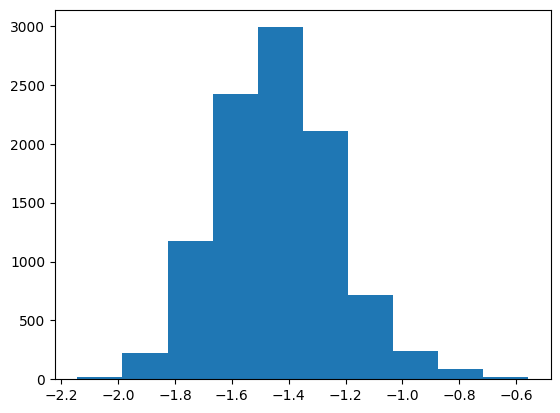

In [28]:
plt.hist(angle_training[:, -1])
plt.show()

In [29]:
np.pi/2

1.5707963267948966